In [1]:
library(ggplot2)
library(repr)
options(repr.plot.width=16, repr.plot.height=10)
library(patchwork)
library('rjags') 

Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Exercise 1

###  Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

### Considering the following to sets of observations taken over a fixed large time interval in two different corps:

$$
\begin{array}{rrrrrrr}
      \text{y death soldiers} |& 0 & 1 & 2 & 3 & 4 & \geq 5 \\
      \hline
      n_1 \text{observations} |& 109 & 65 & 22 & 3 & 1 & 0 \\
      n_2 \text{observations} |& 144 & 91 & 32 & 11 & 2 & 0\\
\end{array}
$$

### a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.

If we assume a uniform prior, then the posterior becomes:

$P(\mu | {y_j}) \propto f({y_j}|\mu) \times g(\mu) \propto \mu^{\sum y_j} e^{-n\mu}$

$(g(\mu) = 1 \; \text{for} \; \mu > 0 ) \; \rightarrow $ a Gamma distribution with $\alpha = \sum y_j + 1$ and $\lambda = n$.

In [2]:
y <- c(0, 1, 2, 3, 4)
n1 <- c(109, 65, 22, 3, 1)

p_step <- 0.0001
p <- seq(0, 5, length.out = 1/p_step)


alpha1_uni <- sum(n1*y) + 1
lambda1_uni <- sum(n1)


posterior1_uni <- dgamma(p, alpha1_uni, lambda1_uni)

It is interesting to see, what happens if we consider a posterior for the first set of measurements as a prior for the second one.

In this case with Gamma prior the posterior is also a Gamma distribution with $\alpha_2 = \alpha_1 + \sum y_j$ and $\lambda_2 = \lambda_1 + n$.

In [3]:
n2 <- c(144, 91, 32, 11, 2)
alpha2_uni <- alpha1_uni + sum(n2*y)
lambda2_uni <- lambda1_uni + sum(n2)


posterior2_uni <- dgamma(p, alpha2_uni, lambda2_uni)

In [4]:
mean_var_median_for_gamma <- function(alpha, lambda, prior, set) {
    
mean <- round(alpha/lambda,3)
var <- round(alpha/lambda**2,3)
median <- round(qgamma(0.5, alpha, lambda), 3)
    
print(set)

cat('Mean of the posterior for a', prior, 'prior:', mean, '\n')
cat('Variance of the posterior for', prior, 'prior:', var, '\n')
cat('Median of the posterior for a', prior, 'prior:', median, '\n')
    
return(list('mean' = mean,
            'var' = var,
            'median' = median))   
}


char1_uni <- mean_var_median_for_gamma(alpha1_uni, lambda1_uni, 'uniform', 'set1')
char2_uni <- mean_var_median_for_gamma(alpha2_uni, lambda2_uni, 'based on set1', 'set2')

[1] "set1"
Mean of the posterior for a uniform prior: 0.615 
Variance of the posterior for uniform prior: 0.003 
Median of the posterior for a uniform prior: 0.613 
[1] "set2"
Mean of the posterior for a based on set1 prior: 0.665 
Variance of the posterior for based on set1 prior: 0.001 
Median of the posterior for a based on set1 prior: 0.664 


In [5]:
ci_limits <- function(q, alpha, lambda){
    lower_limit <- qgamma(q, alpha, lambda)
    upper_limit <- qgamma(1-q, alpha, lambda)
    return( list('lower' = lower_limit,
                 'upper' = upper_limit))
}


limits1_uni <- ci_limits(0.025, alpha1_uni, lambda1_uni)
limits2_uni <- ci_limits(0.025, alpha2_uni, lambda2_uni)


cat('Set n1: 95% credibility interval: [', round(limits1_uni$lower,3),
    ',', round(limits1_uni$upper,3), ']', sep='', '\n')

cat('Set n2: 95% credibility interval: [', round(limits2_uni$lower,3),
    ',', round(limits2_uni$upper,3), ']', sep='', '\n')

Set n1: 95% credibility interval: [0.511,0.728]
Set n2: 95% credibility interval: [0.594,0.739]


Warning message:
“Removed 9000 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 9000 rows containing missing values (`geom_line()`).”


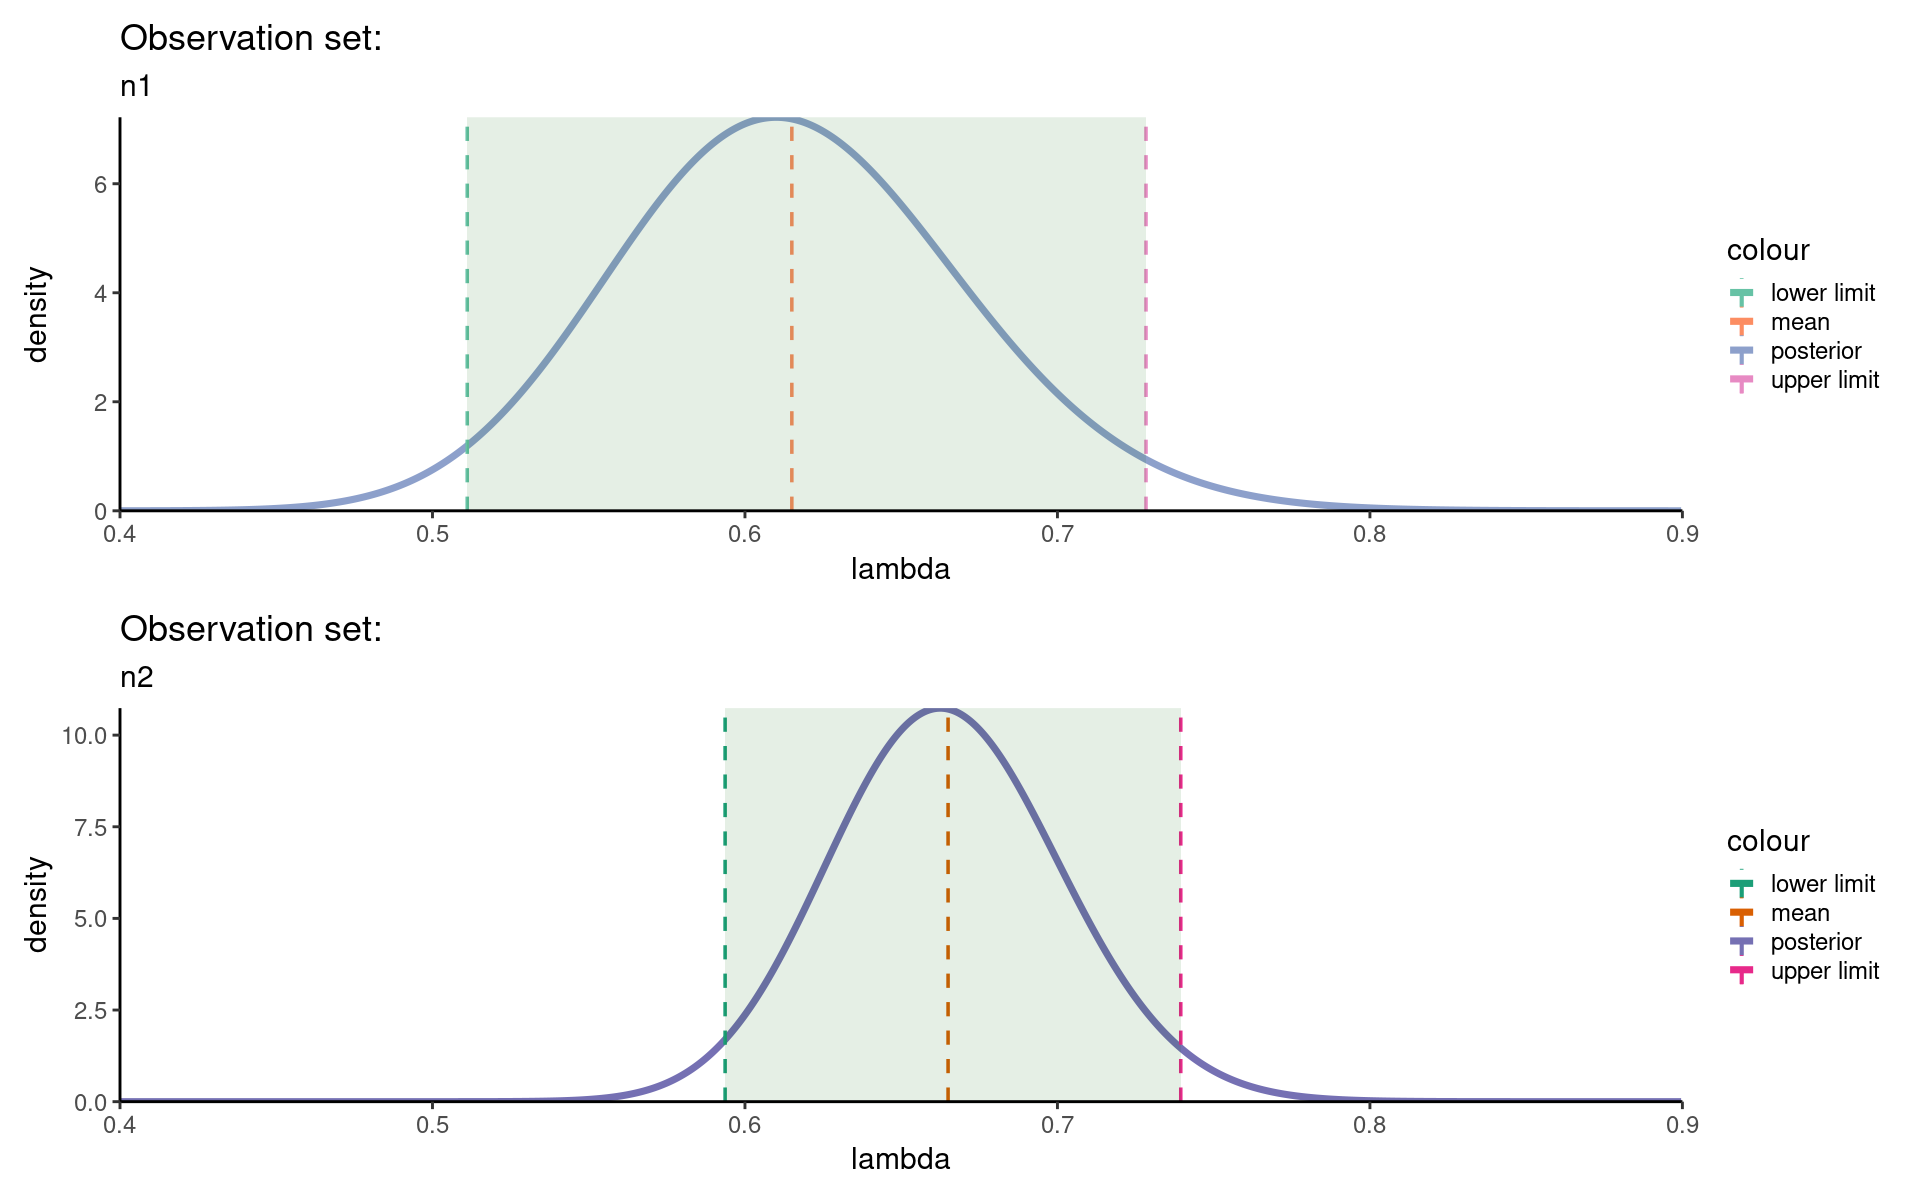

In [6]:
plotting_95 <- function(posterior, name_post, char, limits, set, num) {
    ggplot() +
    geom_line(aes(x = p, y = posterior, colour = 'posterior'), linewidth = 2) +
    geom_vline(aes(xintercept = char$mean, colour = 'mean'), linetype = 'dashed', linewidth = 1) +
    geom_vline(aes(xintercept = limits$lower, colour = 'lower limit'), linetype = 'dashed', linewidth = 1) +
    geom_vline(aes(xintercept = limits$upper, colour = 'upper limit'), linetype = 'dashed', linewidth = 1) +
    geom_ribbon(aes(y = posterior, xmax = limits$upper, xmin = limits$lower),
            fill = 'darkgreen', alpha=0.1) +
    scale_x_continuous(name= 'lambda',expand = c(0, 0), limits=c(0.4,0.9))+
    scale_y_continuous(name = 'density', expand = c(0, 0))+
    theme_classic(base_size=18) +
    scale_color_brewer(palette = set)  +
    ggtitle('Observation set:', num)
    }

p1_uni <- plotting_95(posterior1_uni, 'posterior for a uniform prior',
                      char1_uni, limits1_uni, 'Set2', 'n1')
p2_uni <- plotting_95(posterior2_uni, 'posterior for a prior based on set1',
                      char2_uni, limits2_uni, 'Dark2', 'n2')

p1_uni / p2_uni

### b) assuming now a Jeffreys’ prior,

$$
g(\lambda) \propto \frac{1}{\sqrt{\lambda}} \; \text{with} \lambda > 0
$$

### compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.


With Jeffrey's prior the posterior is a Gamma distribution with $\alpha = \sum y_j + \frac{1}{2}$ and $\lambda = n$.

For the second set we still will assume posterior for the first one as a prior.

[1] "set1"
Mean of the posterior for a Jeffreys prior: 0.613 
Variance of the posterior for Jeffreys prior: 0.003 
Median of the posterior for a Jeffreys prior: 0.611 
[1] "set2"
Mean of the posterior for a based on set1 prior: 0.664 
Variance of the posterior for based on set1 prior: 0.001 
Median of the posterior for a based on set1 prior: 0.663 
Set n1: 95% credibility interval: [0.509,0.726]
Set n2: 95% credibility interval: [0.593,0.738]


Warning message:
“Removed 9000 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 9000 rows containing missing values (`geom_line()`).”


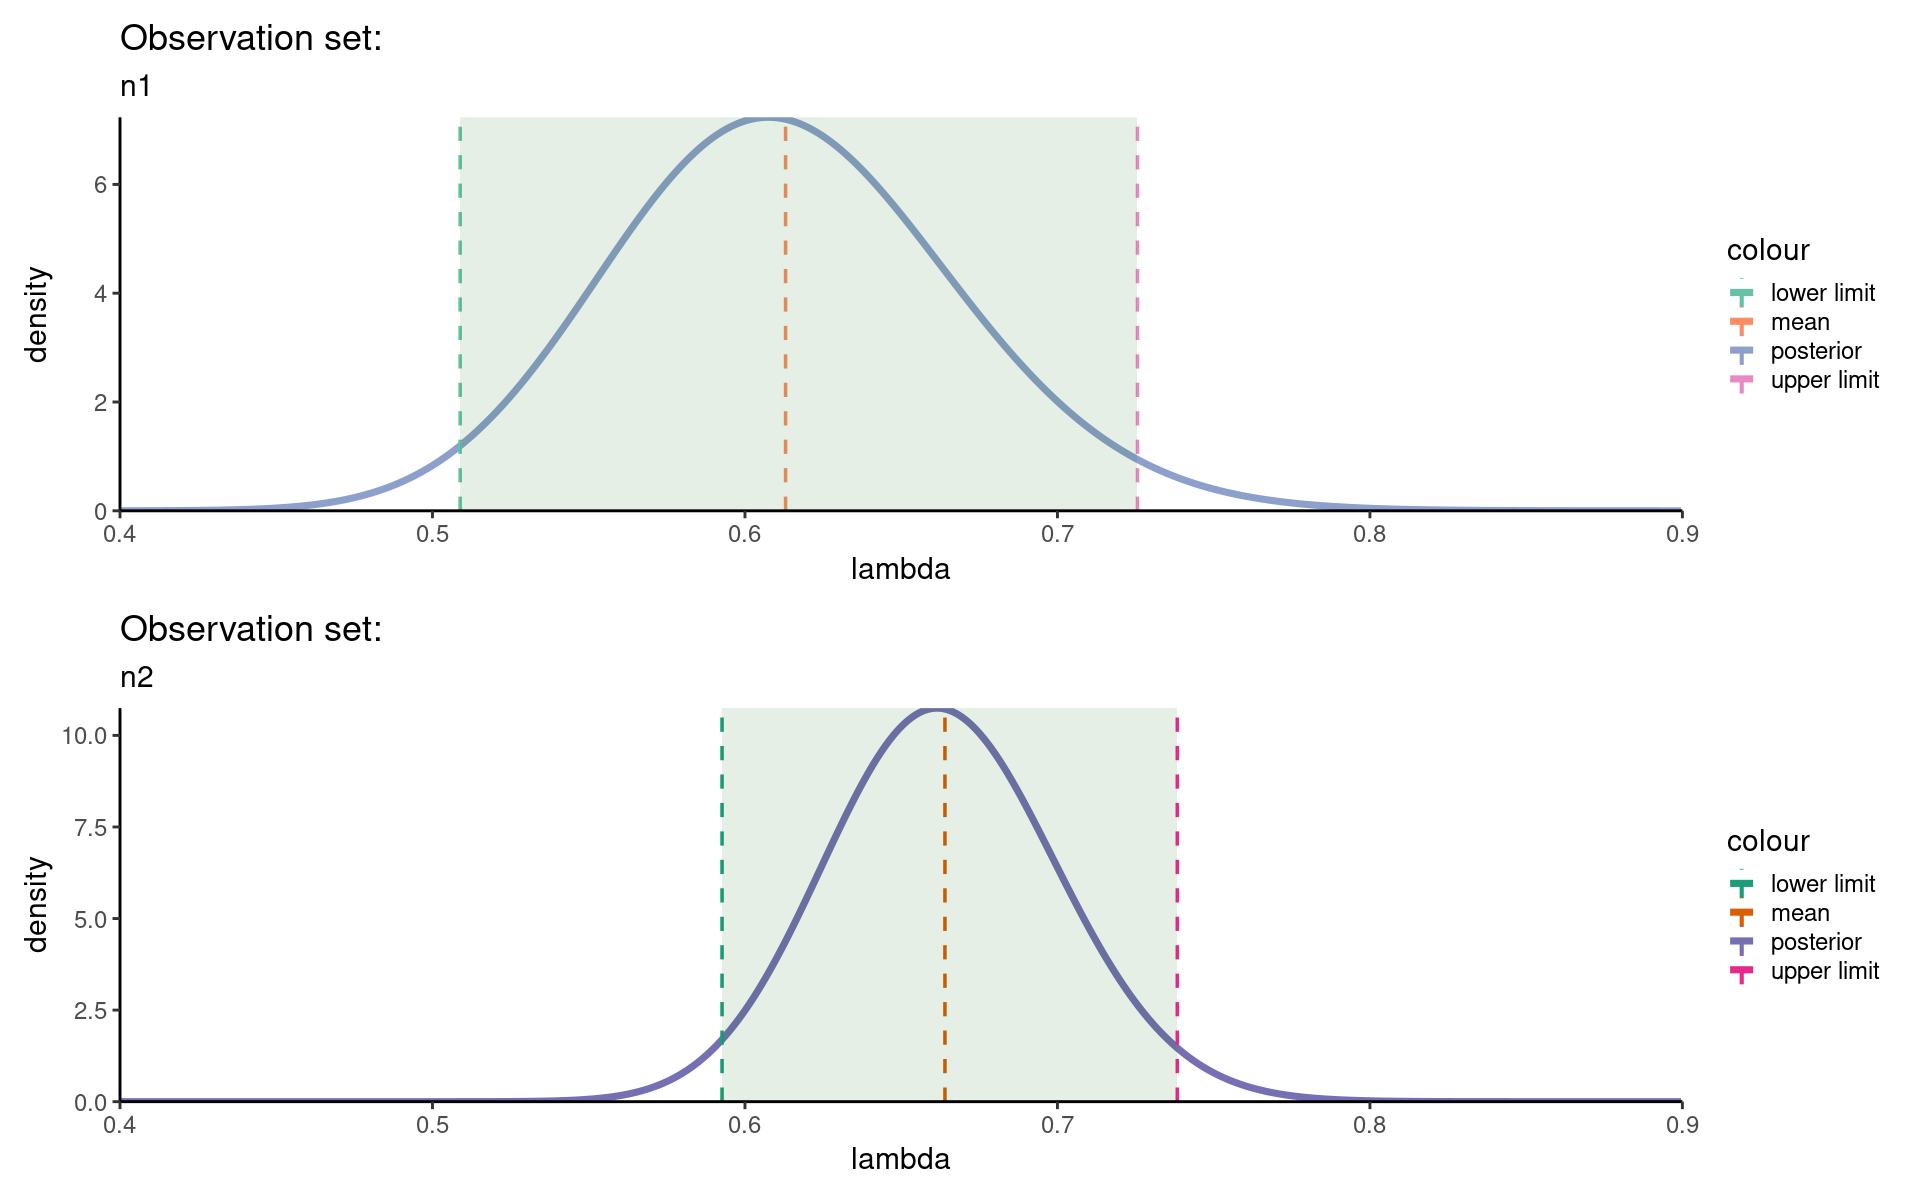

In [7]:
alpha1_jef <- sum(n1*y) + 0.5
lambda1_jef <- sum(n1)


prior1_jef <- dgamma(p, 0.5, 0)
posterior1_jef <- dgamma(p, alpha1_jef, lambda1_jef)


prior2_jef <- posterior1_jef
alpha2_jef <- alpha1_jef + sum(n2*y)
lambda2_jef <- lambda1_jef + sum(n2)
posterior2_jef <- dgamma(p, alpha2_jef, lambda2_jef)



char1_jef <- mean_var_median_for_gamma(alpha1_jef, lambda1_jef, 'Jeffreys', 'set1')
char2_jef <- mean_var_median_for_gamma(alpha2_jef, lambda2_jef, 'based on set1', 'set2')



limits1_jef <- ci_limits(0.025, alpha1_jef, lambda1_jef)
limits2_jef <- ci_limits(0.025, alpha2_jef, lambda2_jef)

cat('Set n1: 95% credibility interval: [', round(limits1_jef$lower,3),
    ',', round(limits1_jef$upper,3), ']', sep='', '\n')

cat('Set n2: 95% credibility interval: [', round(limits2_jef$lower,3),
    ',', round(limits2_jef$upper,3), ']', sep='', '\n')


p1_jef <- plotting_95(posterior1_jef, 'posterior for a Jeffreys prior',
                      char1_jef, limits1_jef, 'Set2', 'n1')
p2_jef <- plotting_95(posterior2_jef, 'posterior for a prior based on set1',
                      char2_jef, limits2_jef, 'Dark2', 'n2')

p1_jef / p2_jef

# Exercise 2

###  Solve Exercise 1 with a Markov Chain Monte Carlo. Build your own MCMC, using the functions introduced during lectures, or using a MCM library like JAGS.

1) Uniform prior

In this exersice I assume the same prior for both sets.

In [8]:
model_uni <- "model{
    # Likelihood model for X
    for (i in 1:length(X)) {
    X[i] ~ dpois(lambda)
    }
    
    # a uniform prior for lambda
    lambda ~ dexp(0.00001)
     
    #predicted data, given lambda
    
    Y ~ dpois(lambda);
}"

In [9]:
Markov_chain_jags <- function(model, data, colour1, colour2, colour3){
    #compiling the model
    model_deaths <- jags.model(textConnection(model), 
    data = data)
    update(model_deaths, 1000)

    #posterior simulation
    chain <- coda.samples(model = model_deaths, variable.names = c("lambda","Y"),
                          n.iter = 10000)

    plot(chain, col=colour1)
    
    print(summary(chain))
    
    options(repr.plot.width=16, repr.plot.height=8)
    chain.df <- as.data.frame(as.mcmc(chain))
    #
    # Probability plots
    par(mfrow=c(1,2))
    hist(chain.df$lambda , nc=100, prob=TRUE , col=colour2,
    xlim=c(0.2, 1),
    xlab='lambda ', ylab='f(lambda)', main='Inference on lambda')
    ty <- table(chain.df$Y)
    barplot(ty/sum(ty), col=colour3, xlab='Y', ylab='f(Y)', main= sprintf('Predicted counts'))
    
}

Set1, Uniform prior 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 203

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
Y      0.6055 0.77545 0.0077545      0.0077545
lambda 0.6143 0.05501 0.0005501      0.0005501

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
Y      0.0000 0.0000 0.0000 1.0000 2.0000
lambda 0.5114 0.5765 0.6118 0.6502 0.7275



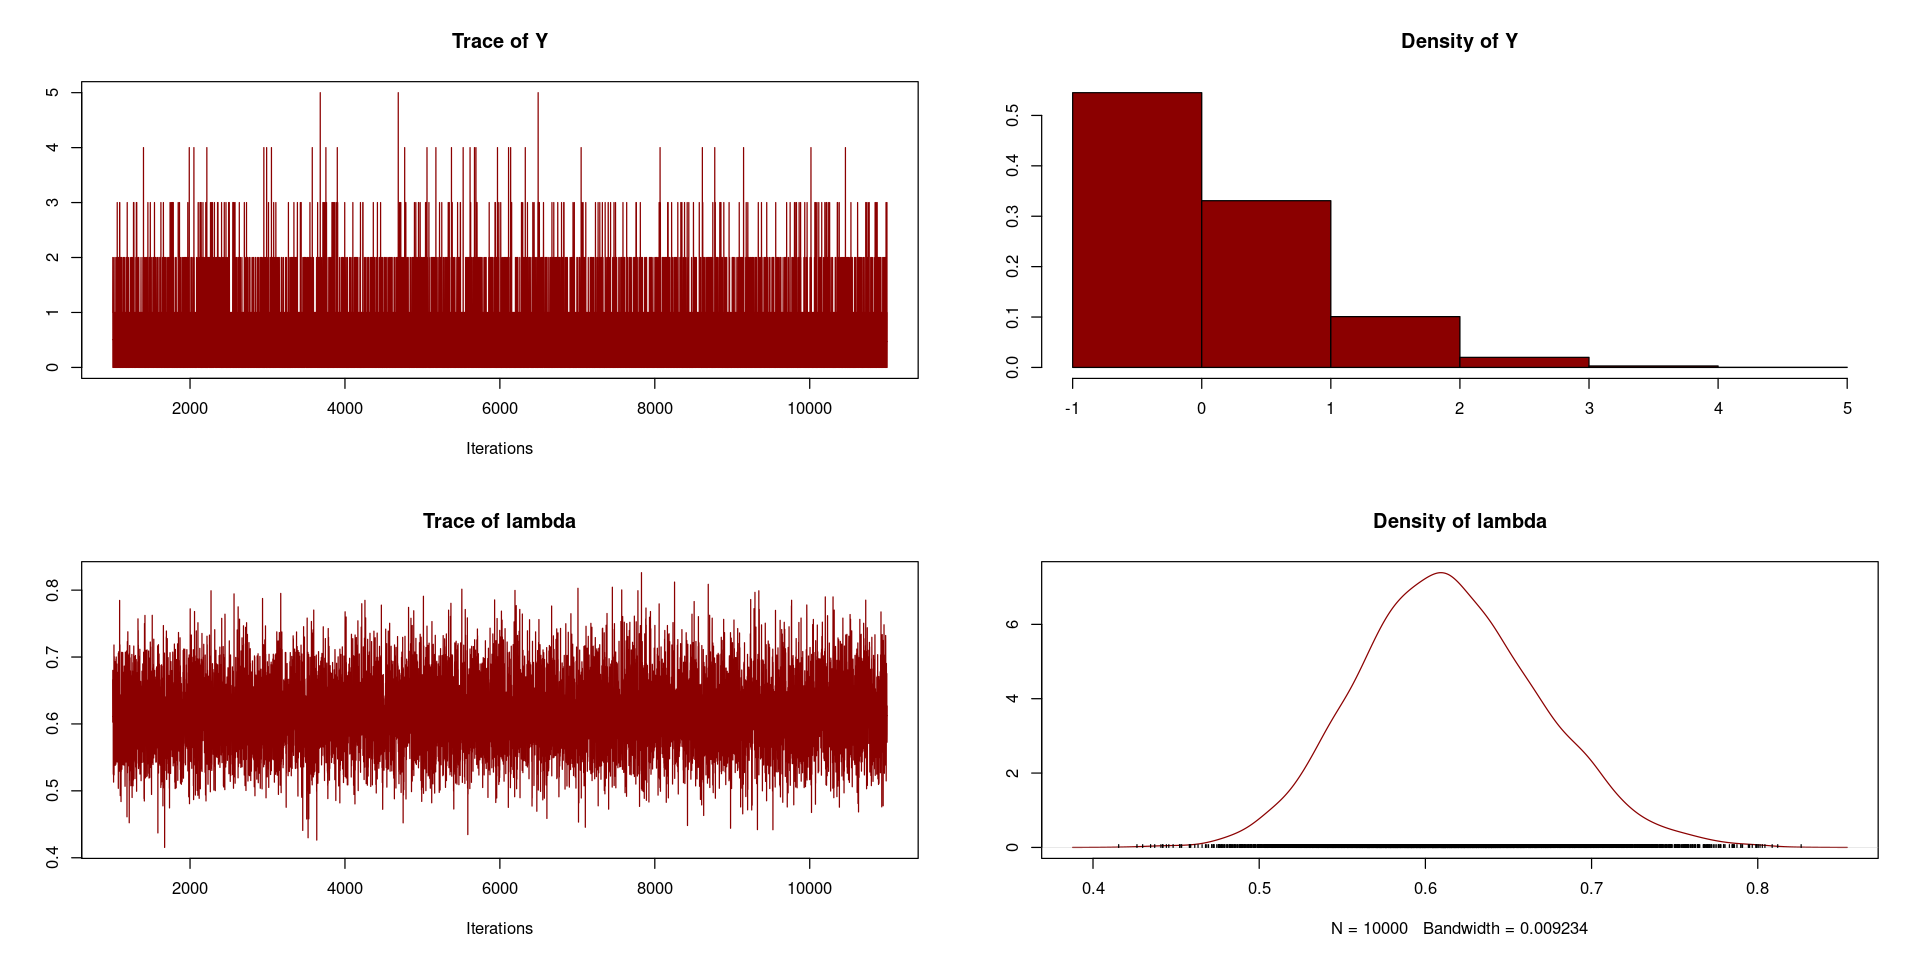

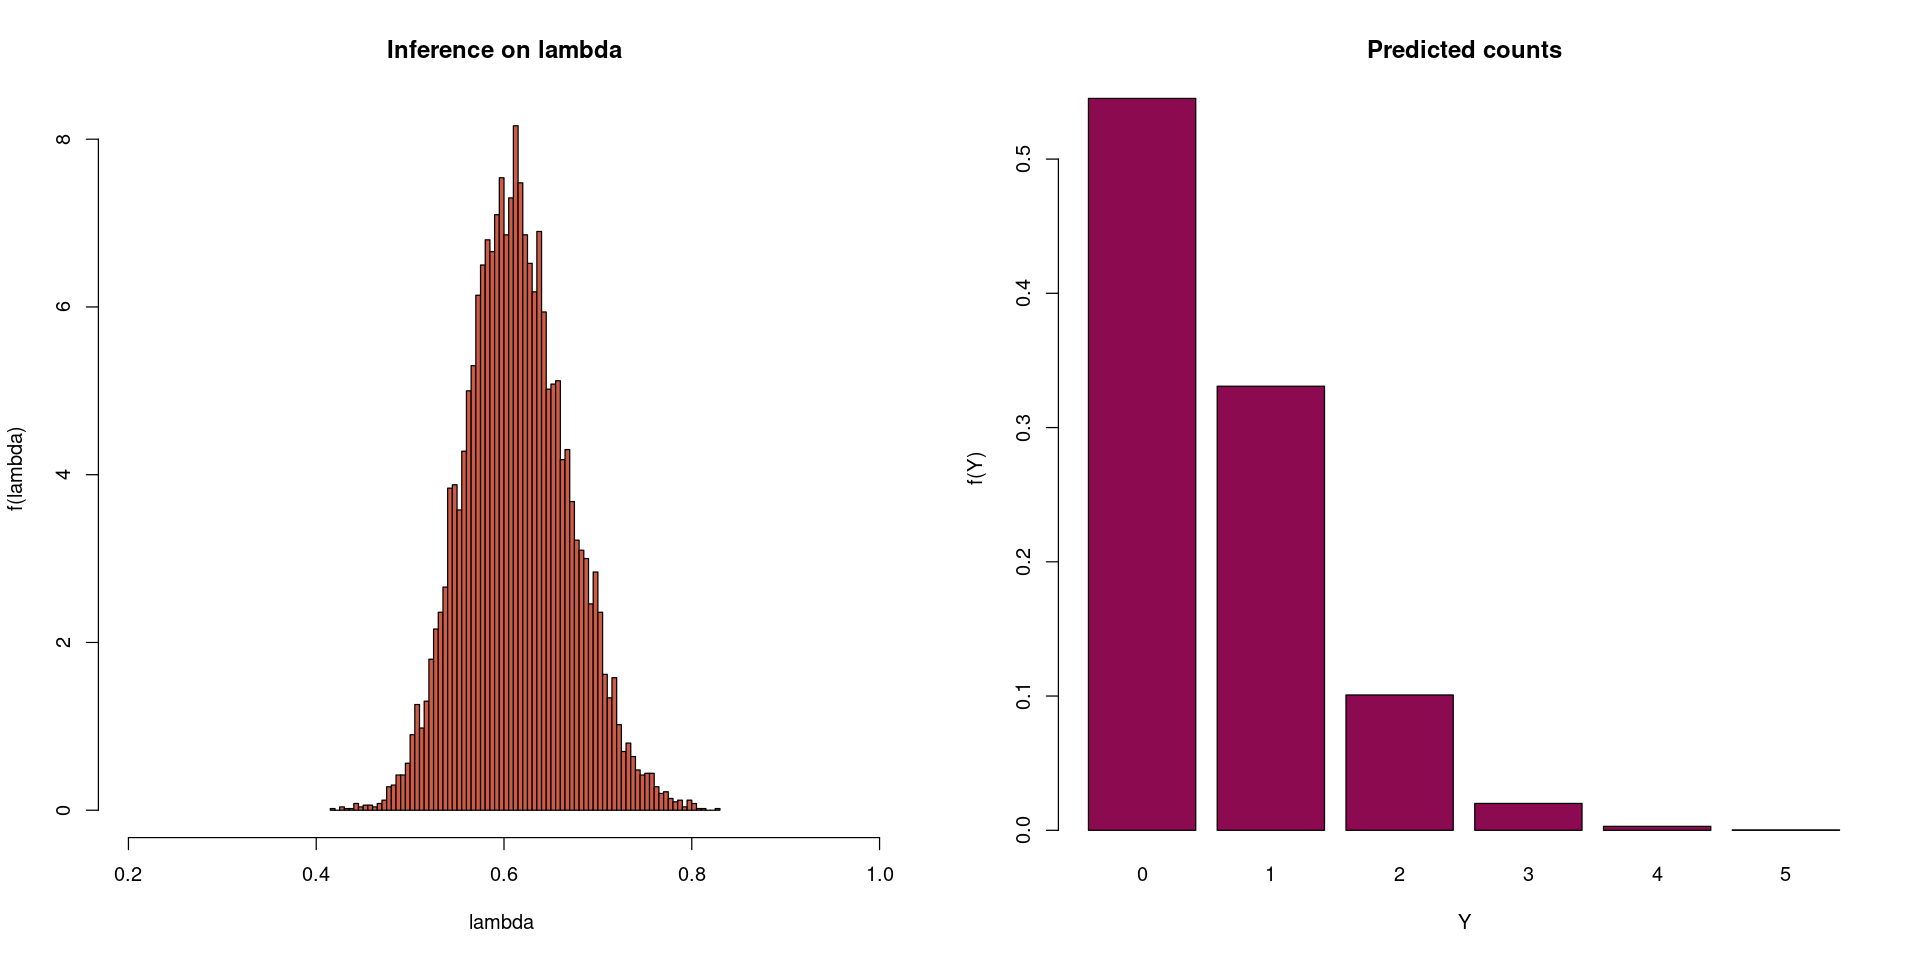

In [10]:
data_n1 <- NULL
data_n1$X <- rep(y, n1)

cat('Set1, Uniform prior \n')
Markov_chain_jags(model_uni, data_n1, 'darkred', 'coral3', 'deeppink4')

Set2, Uniform prior 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 283

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
Y      0.7113 0.83715 0.0083715      0.0083715
lambda 0.7030 0.05025 0.0005025      0.0005139

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
Y      0.000 0.0000 1.0000 1.0000 3.0000
lambda 0.607 0.6687 0.7017 0.7358 0.8047



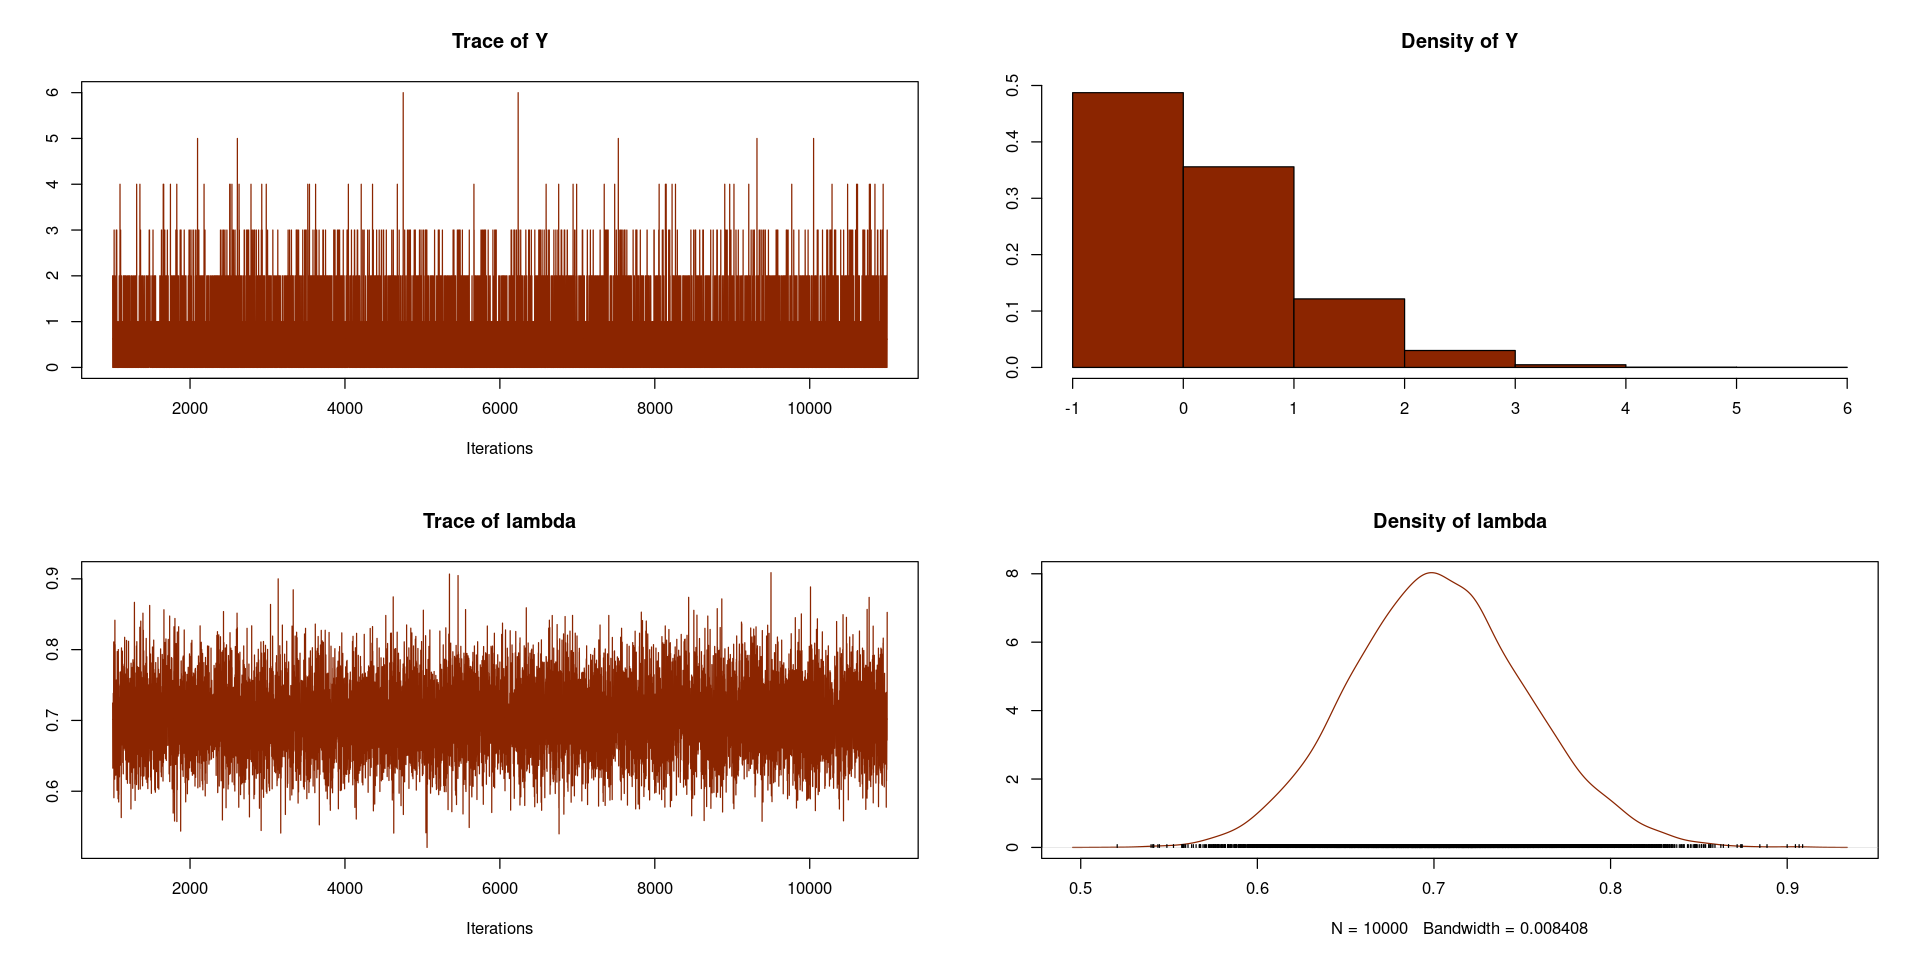

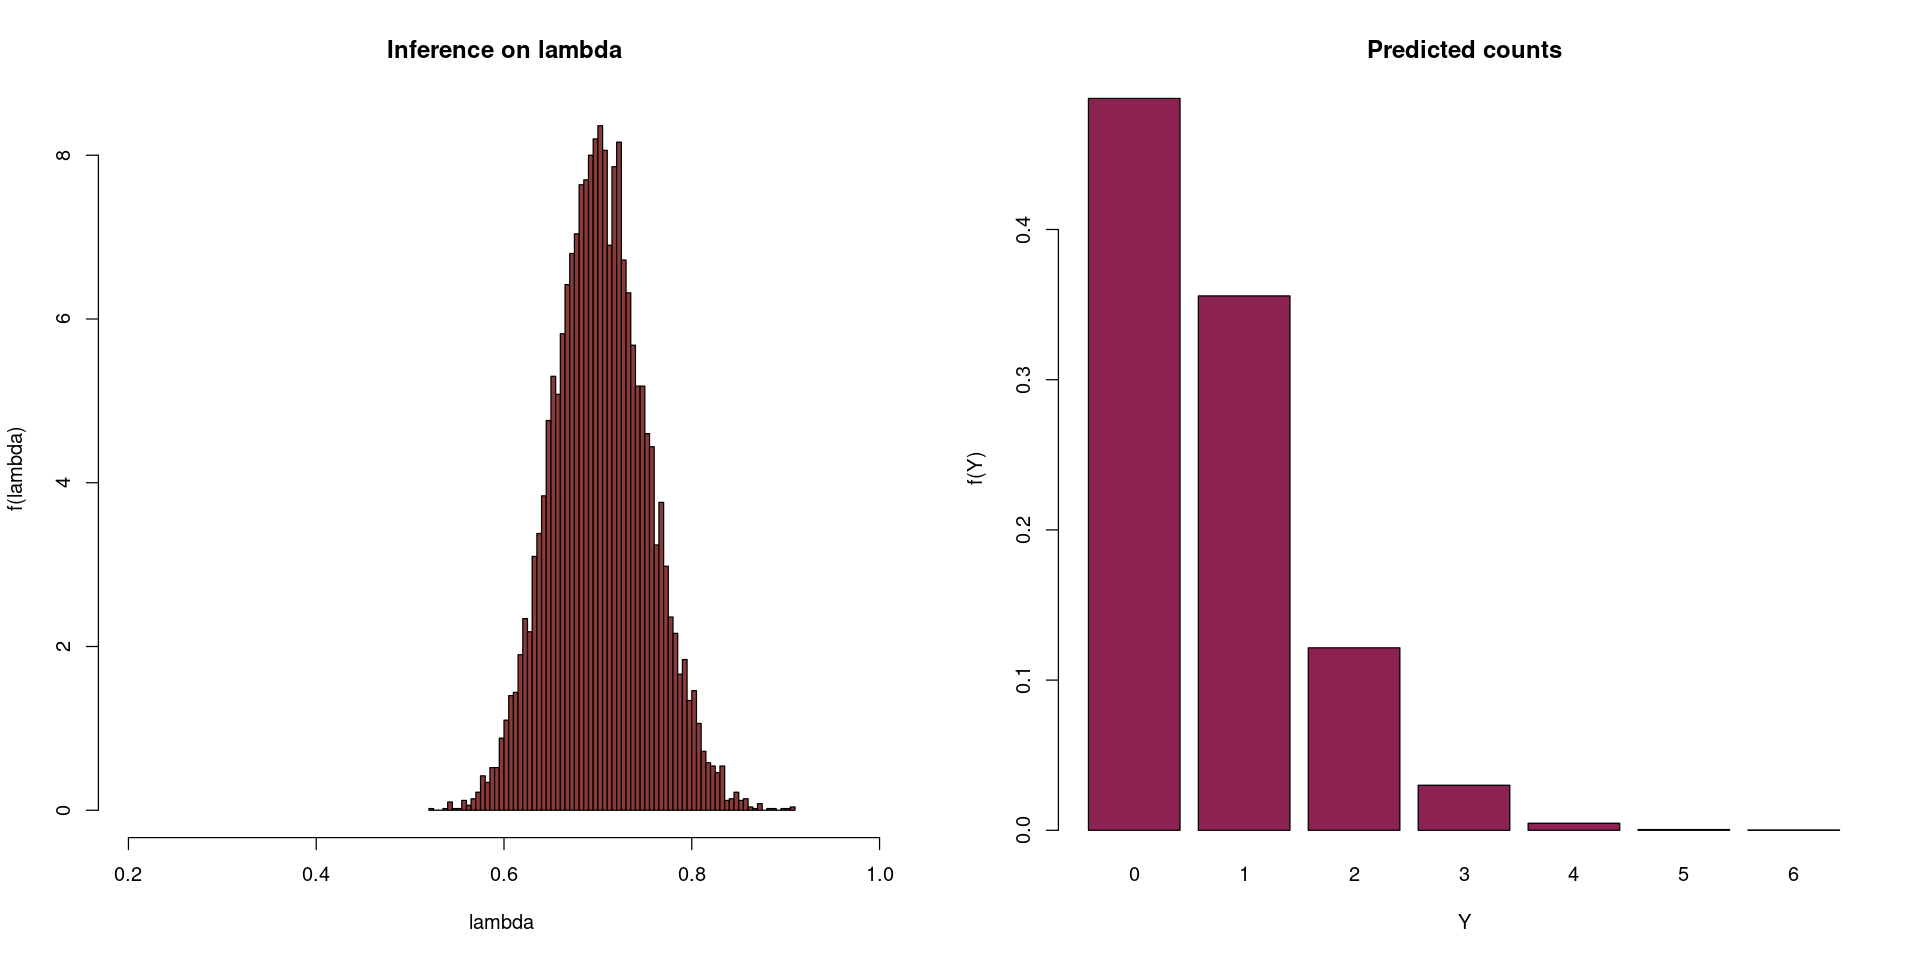

In [11]:
data_n2 <- NULL
data_n2$X <- rep(y, n2)

cat('Set2, Uniform prior \n')
Markov_chain_jags(model_uni, data_n2, 'orangered4', 'indianred4', 'violetred4')

2) Jeffrey's prior

In [12]:
model_jeff <- "model{
    # Likelihood model for X
    for (i in 1:length(X)) {
    X[i] ~ dpois(lambda)
    }
    
    # a Jeffrey's prior for lambda
    lambda ~ dgamma(0.5, 0.00001)
     
    #predicted data, given lambda
    
    Y ~ dpois(lambda);
}"

Set1, Jeffreys prior 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 204

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
Y      0.6212 0.7932 0.007932       0.007932
lambda 0.6121 0.0557 0.000557       0.000557

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
Y      0.000 0.0000 0.0000 1.0000 3.0000
lambda 0.507 0.5738 0.6104 0.6481 0.7249



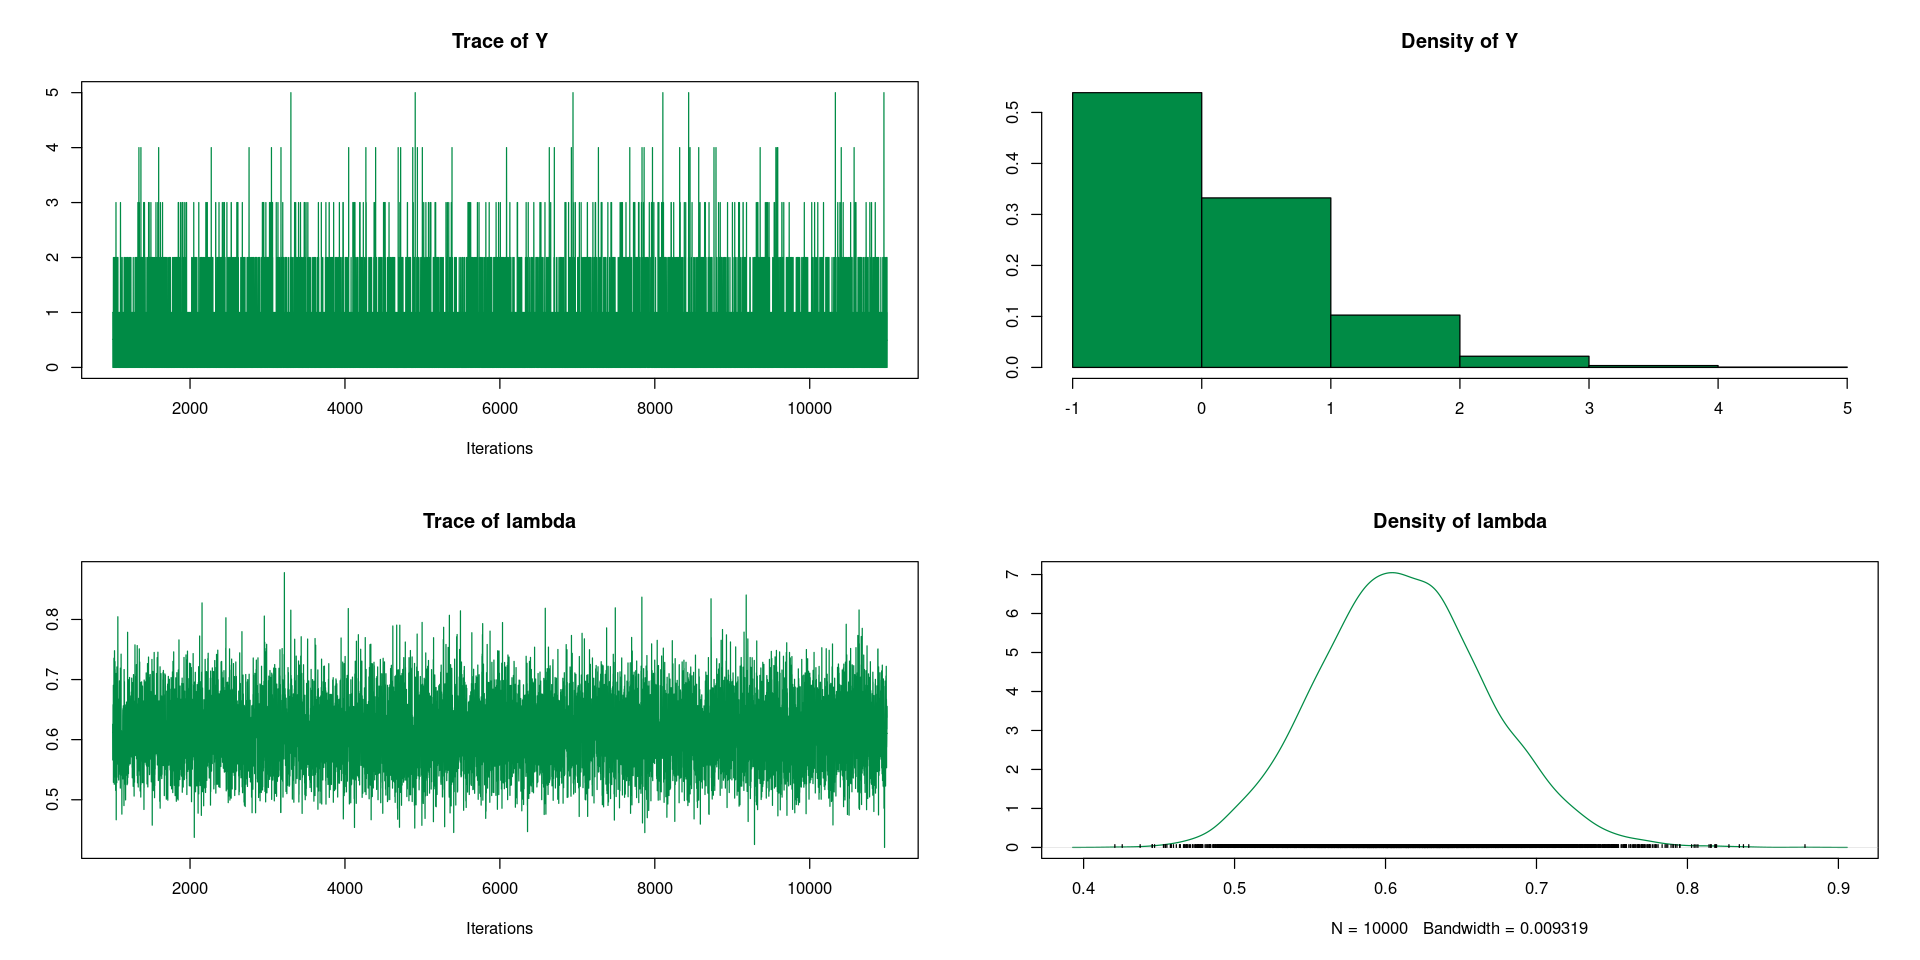

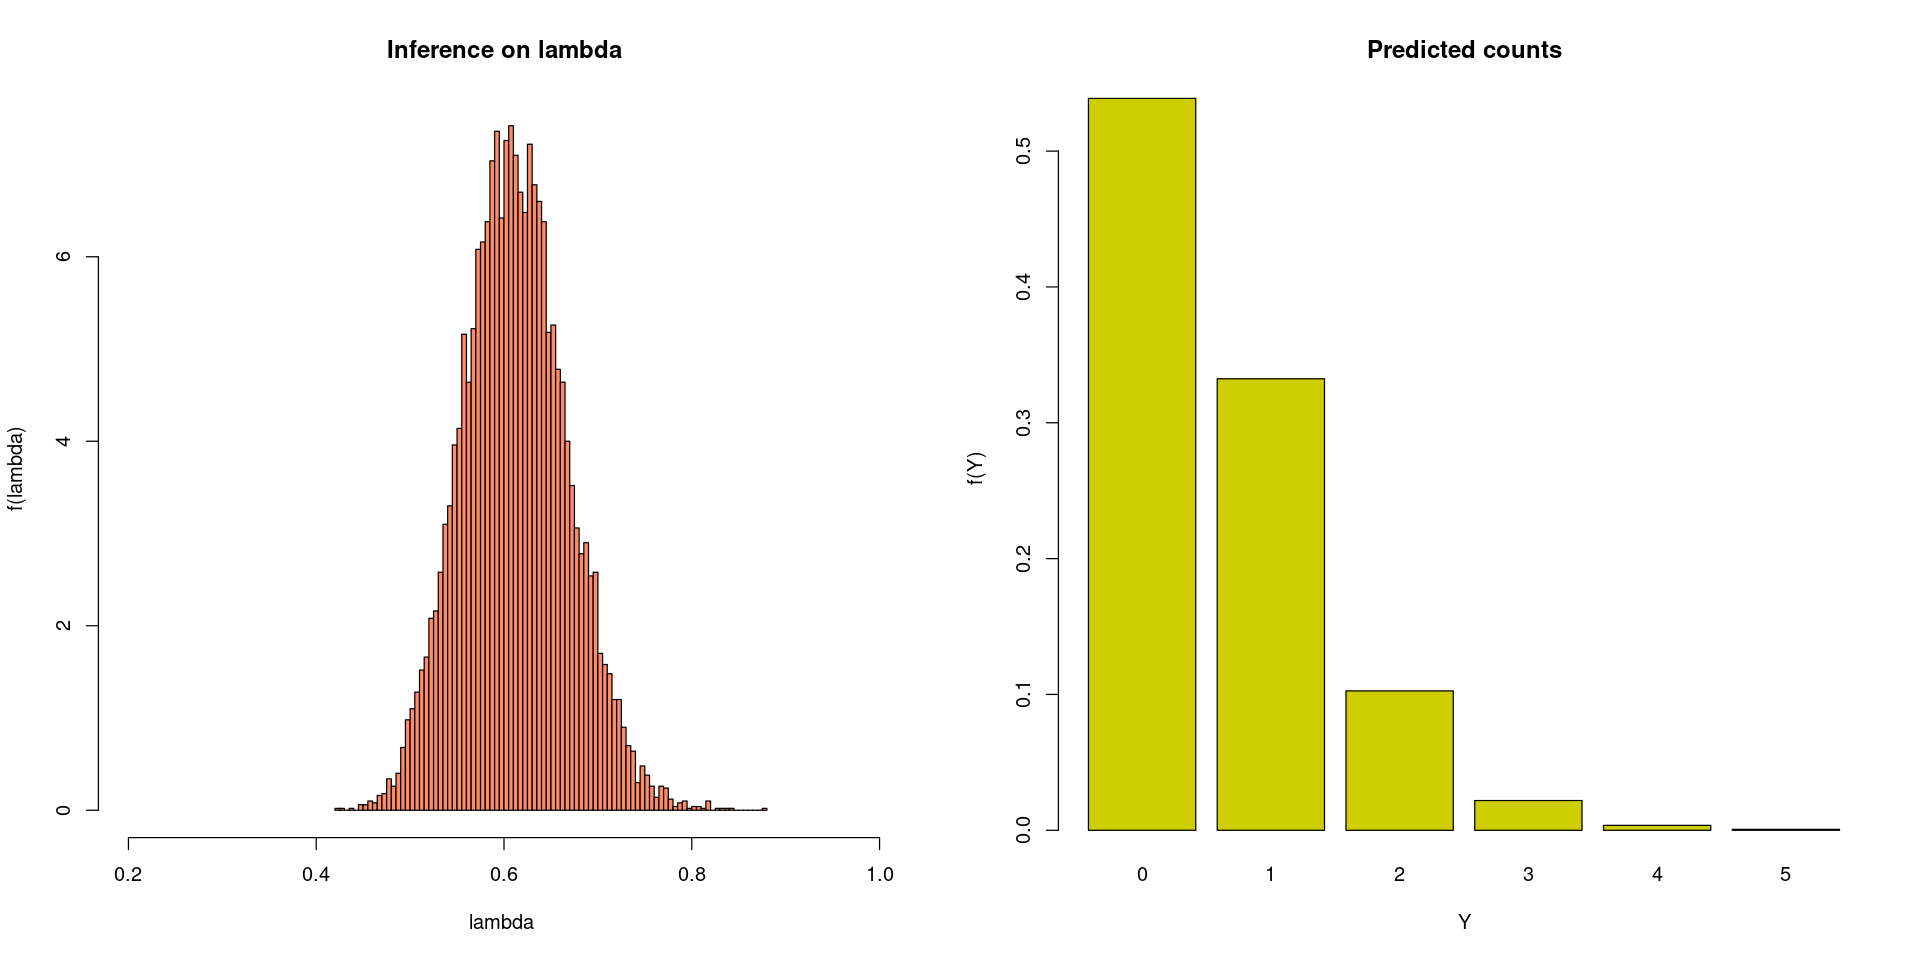

In [13]:
cat('Set1, Jeffreys prior \n')
Markov_chain_jags(model_jeff, data_n1, 'springgreen4', 'salmon1', 'yellow3')

Set2, Jeffreys prior 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 284

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
Y      0.7065 0.85827 0.0085827      0.0085827
lambda 0.7016 0.05021 0.0005021      0.0005021

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
Y      0.0000 0.0000 0.0000 1.0000 3.0000
lambda 0.6086 0.6667 0.6999 0.7351 0.8046



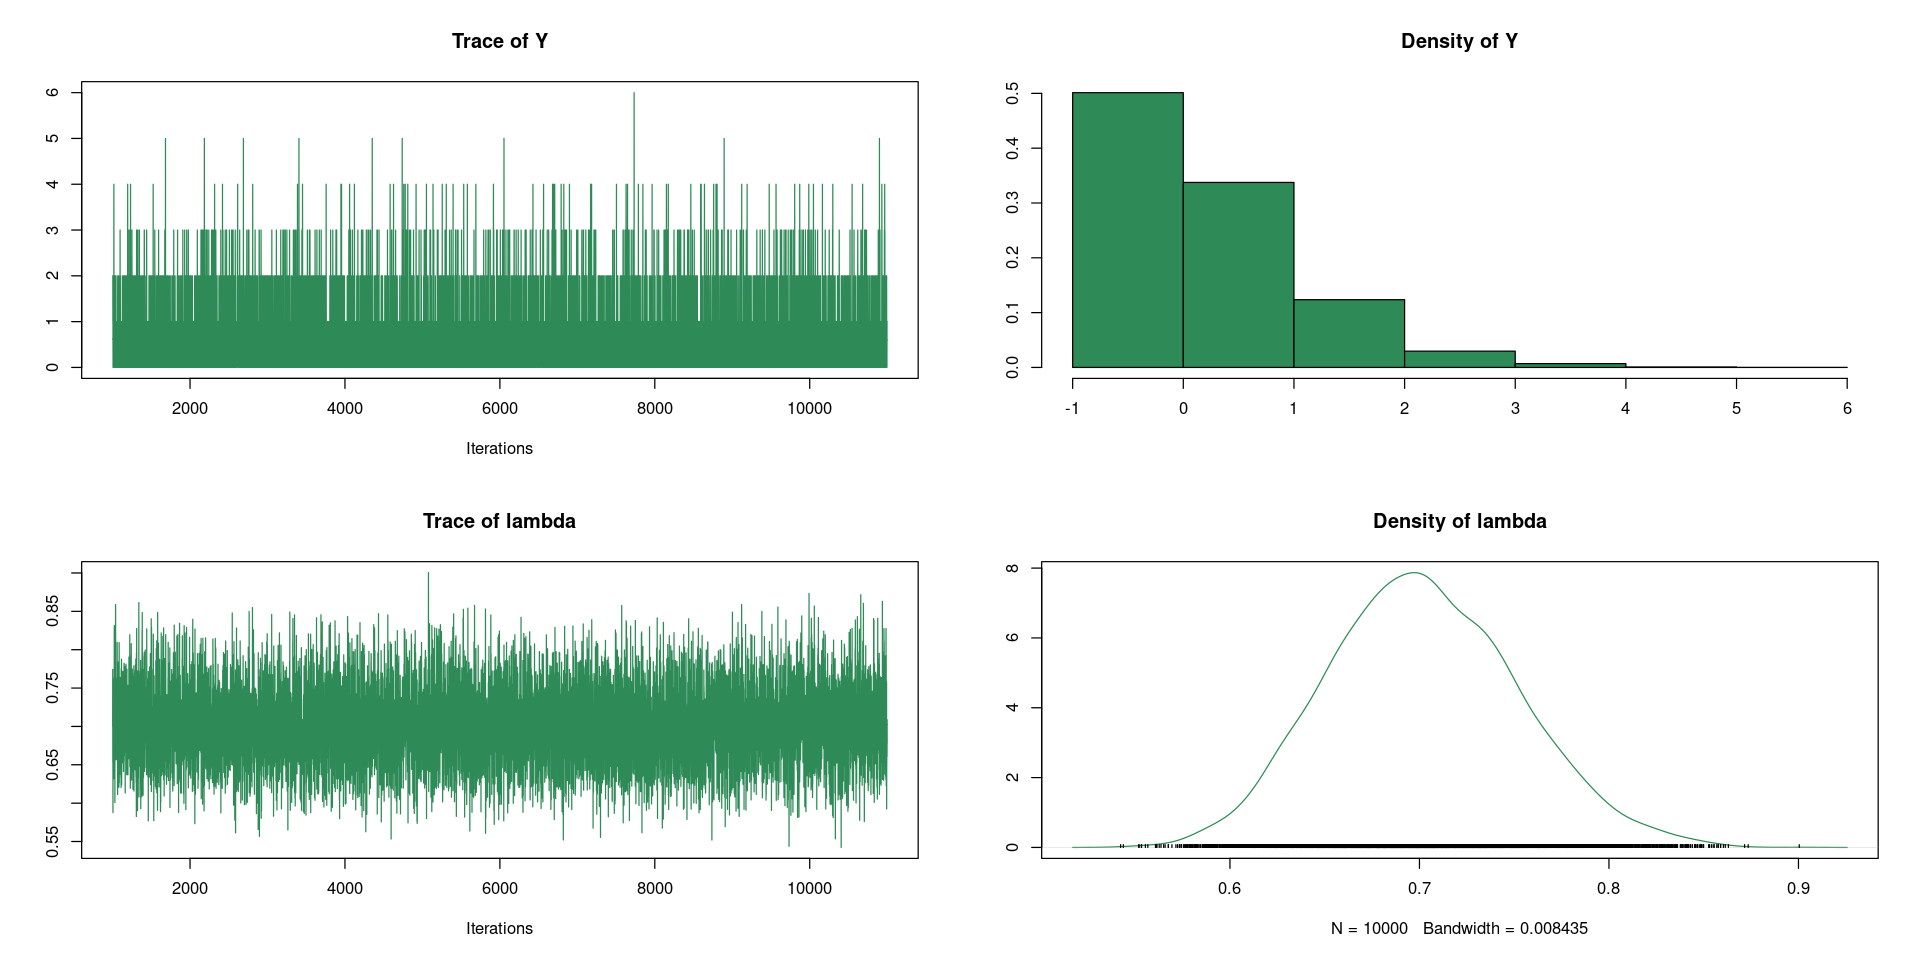

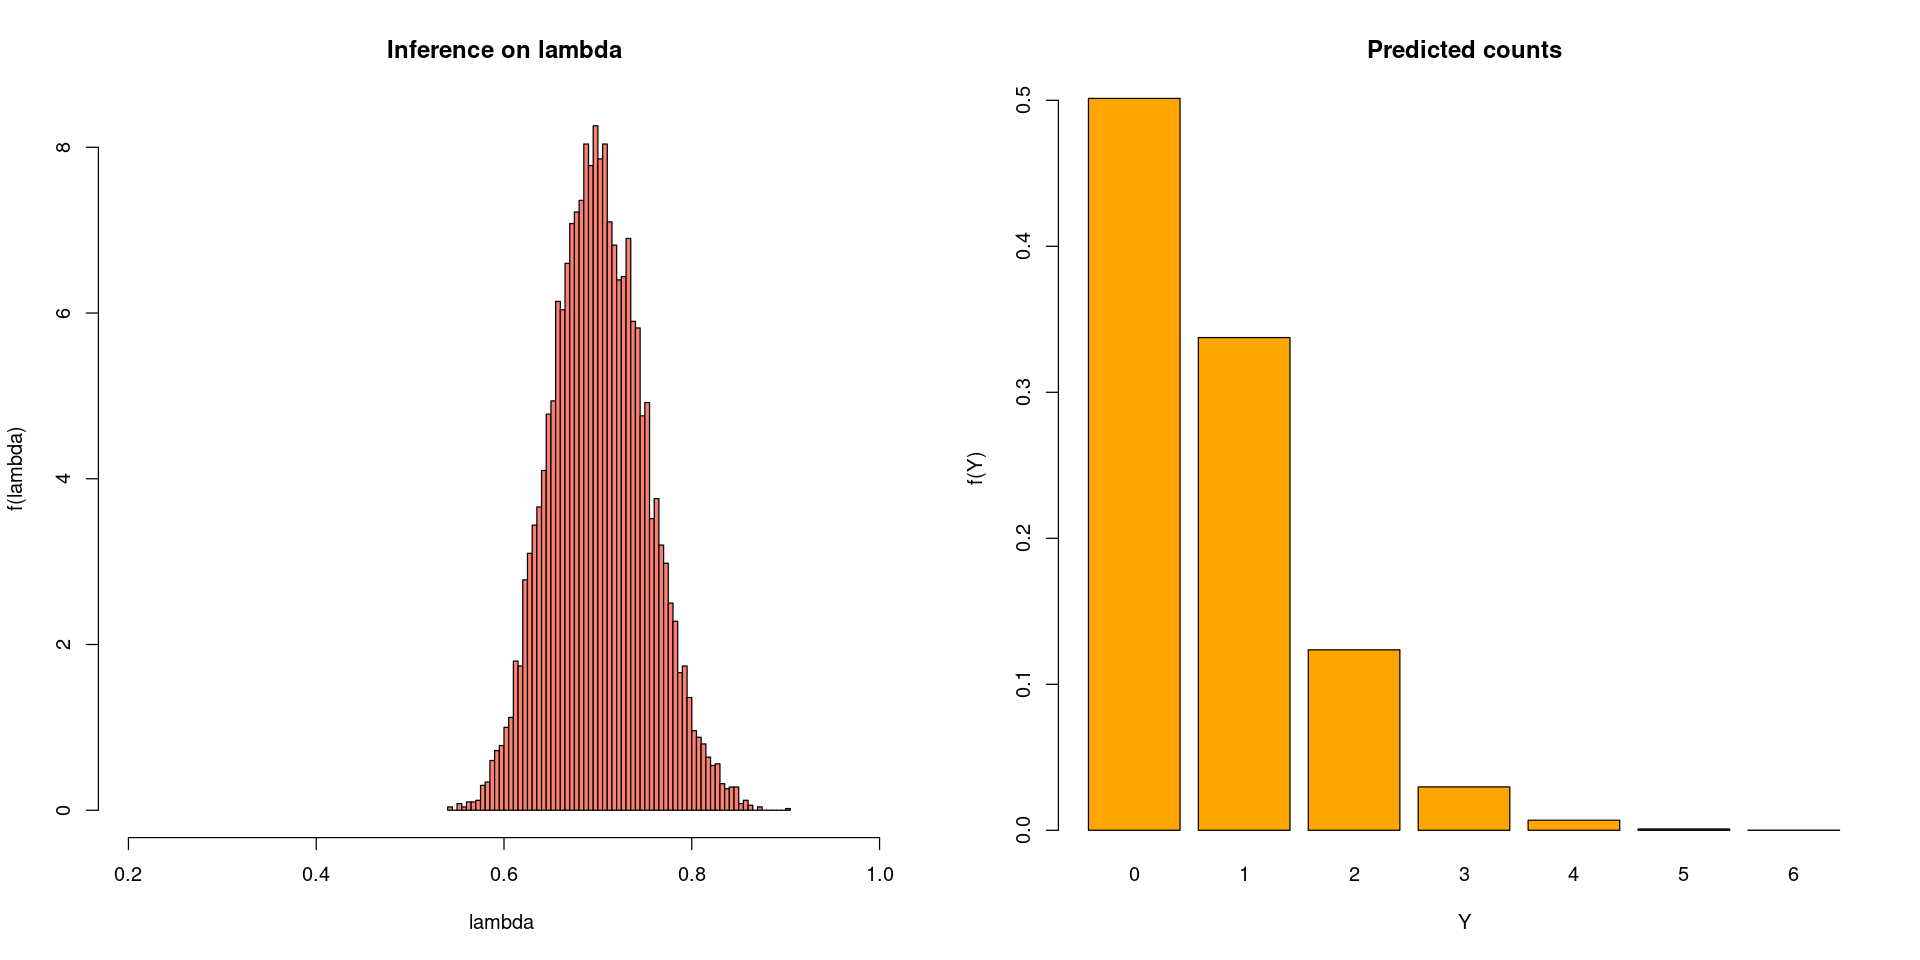

In [14]:
cat('Set2, Jeffreys prior \n')
Markov_chain_jags(model_jeff, data_n2, 'seagreen4', 'salmon', 'orange1')

# Exercise 3

### • A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. n = 116 samples were taken from streams having a high environmental impact on pandas. Out of these, y = 11 had a high bacter X level.

### • indicating with p the probability that a sample of water taken from the stream has a high bacter X level.

### a) find the frequentist estimator for $p$

A frequentist estimator for a Binomial distribution is $p_F = \frac{y}{n}.$

Standard deviation: $\sigma_f = \sqrt{ \frac{p_f(1 - p_f)}{n} }$.

In [15]:
y <- 11
n <- 116

p_f <- y/n
sigma_f <- sqrt(p_f*(1 - p_f)/n)

cat('Frequentist estimator of detecting the bacteria in water sample:',
    round(p_f,3), '\n')
cat('Standard deviation:', round(sigma_f,3))

Frequentist estimator of detecting the bacteria in water sample: 0.095 
Standard deviation: 0.027

### b) using a Beta(1, 10) prior for $p$, calculate posterior distribution P(p∣y)


For a Beta($\alpha, \beta$) as a prior the posterior would be also a Beta distribution with $\alpha' = \alpha + y, \; \beta' = \beta + n - y$.

In [16]:
n_samples <- 1000
delta_p <- 1/n_samples
p <- seq(from = 1/(2*n_samples), by = 1/n_samples, length.out = n_samples)

alpha_prior <- 1
beta_prior <- 10


alpha_post <- alpha_prior + y
beta_post <- beta_prior + n - y

posterior_bayes <- dbeta(p, alpha_post, beta_post)

### c) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval

In [17]:
mean_std_limits <- function(alpha, beta, q){
    mean <- alpha/(alpha + beta)
    std <- (alpha*beta)/((alpha + beta)**2*(alpha + beta + 1))
    lower_limit <- qbeta(q, alpha, beta)
    upper_limit <- qbeta(1-q, alpha, beta)
    return(list('mean' = mean,
               'std' = std,
               'lower' = lower_limit,
               'upper' = upper_limit))
}

vars <- mean_std_limits(alpha_post, beta_post, 0.025)
mean_post <- vars$mean
std_post <- vars$std
lower_limit <- vars$lower
upper_limit <- vars$upper

cat('Mean of the posterior (equal to the Bayesian estimator):',
    round(mean_post,3), '\n')
cat('Variance of the posterior:', std_post**2, '\n')

Mean of the posterior (equal to the Bayesian estimator): 0.094 
Variance of the posterior: 4.468105e-07 


Warning message:
“Removed 700 rows containing missing values (`geom_line()`).”


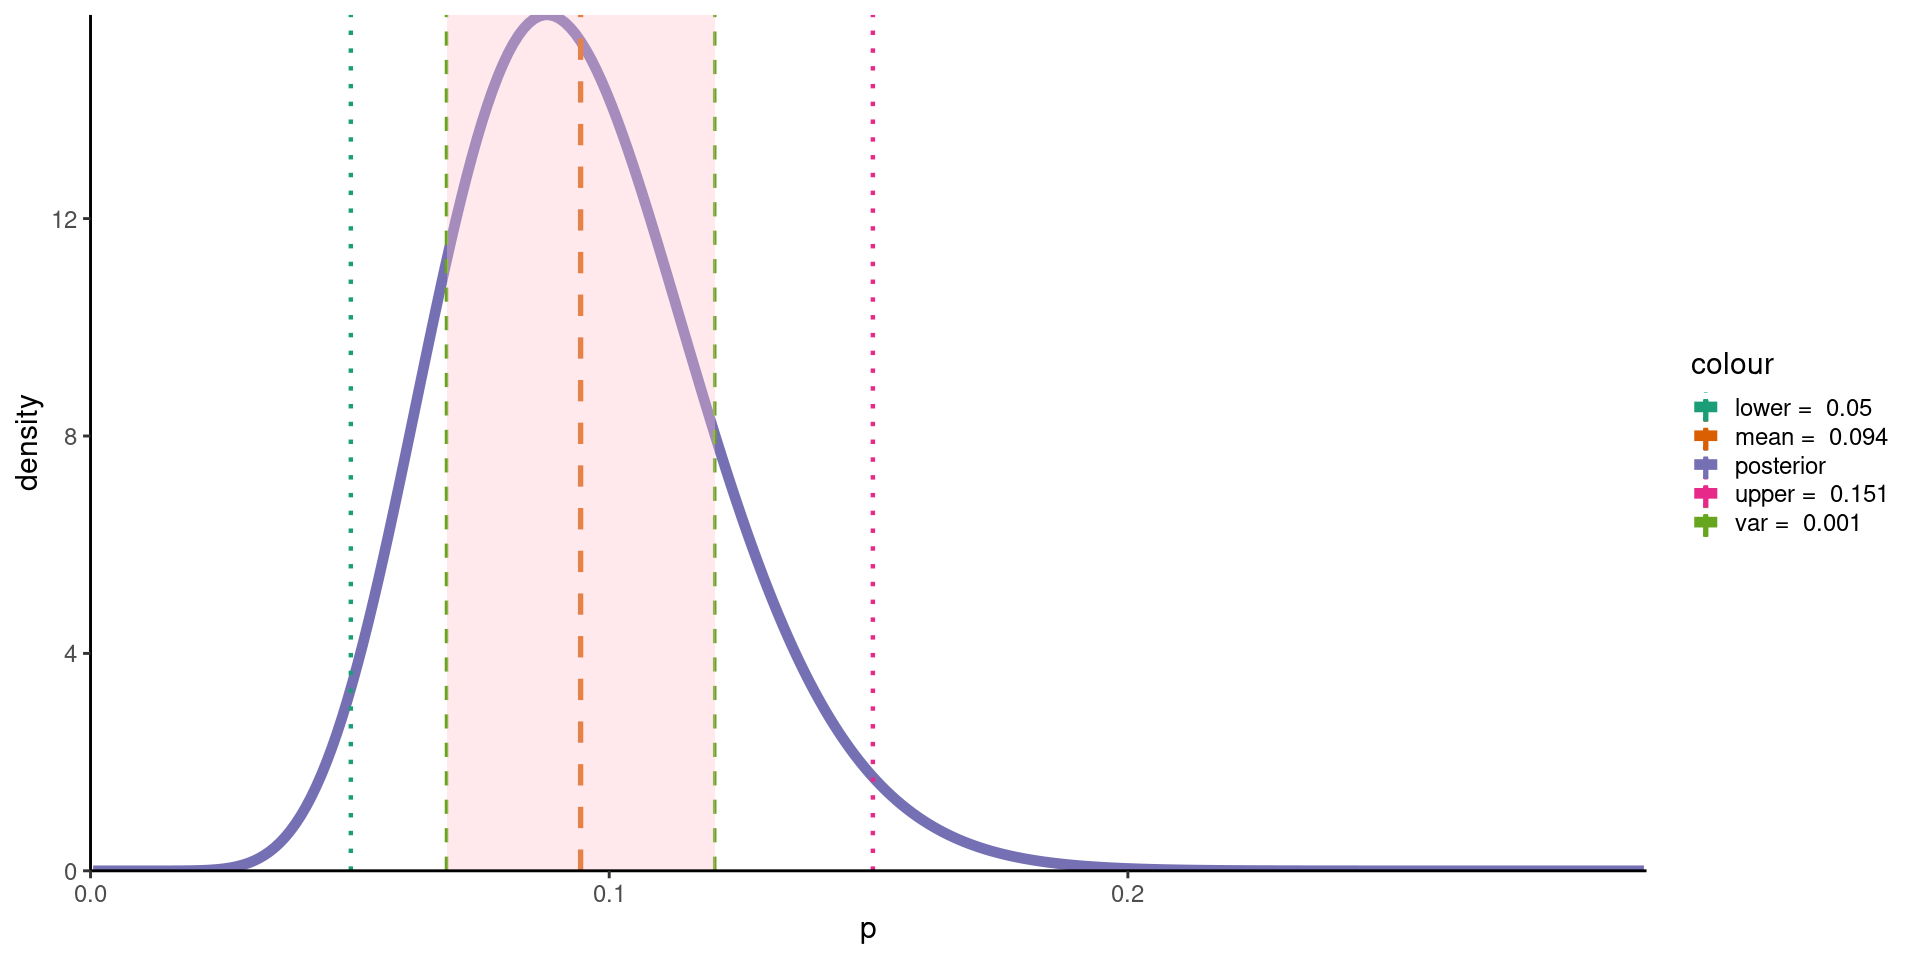

In [18]:
ggplot() +
geom_line(aes(x = p, y = posterior_bayes, colour = 'posterior'), linewidth = 3) +
geom_vline(aes(xintercept = mean_post, colour = paste('mean = ', round(mean_post,3))),
           linetype = 'dashed', linewidth = 1.5) +
geom_vline(aes(xintercept = mean_post - sqrt(std_post),
               colour = paste('var = ', round(std_post,3))),
           linetype = 'dashed', linewidth = 1) +
geom_vline(aes(xintercept = mean_post + sqrt(std_post),
               colour = paste('var = ', round(std_post,3))),
           linetype = 'dashed', linewidth = 1) +
geom_ribbon(aes(y = posterior_bayes, xmax = mean_post - sqrt(std_post),
                xmin = mean_post + sqrt(std_post)),
            fill = 'pink', alpha=0.35) +

geom_vline(aes(xintercept = lower_limit, colour = paste('lower = ', round(lower_limit,3))),
           linetype = 'dotted', linewidth = 1.25) +
geom_vline(aes(xintercept = upper_limit,
               colour = paste('upper = ', round(upper_limit,3))),
           linetype = 'dotted', linewidth = 1.25) +
theme_classic(base_size=18) +
scale_x_continuous(name= 'p',expand = c(0, 0), limits = c(0, 0.3))+
scale_y_continuous(name = 'density', expand = c(0, 0)) +
scale_color_brewer(palette = 'Dark2')

### d) test the hypotesis

$$
H_0 : p = 0.1 \; \text{versus} \; H_1 : p \neq 0.1 
$$

### at 5% level of significance with both the frequentist and bayesian approach

1) Bayesian approach

To test two-side hypothesis we need to check if the $p_0 = 0.1$ is within the $(1-\alpha)\times 100 \%$ interval (in our case $\alpha = 0.05$).

The needed interval is already estimated, so we can give an answer right away:

In [19]:
p_0 <- 0.1

if (p_0 > lower_limit & p_0 < upper_limit){
    cat('Null Hypothesis is accepted.')
} else {cat('Null Hypothesis is rejected.')}

Null Hypothesis is accepted.

2) Frequentist approach

The Null distribution is a sampling distribution of y: Bin(y|n=15, p=0.1).

We need to understand where is the rejection region as close to 5% as possible.

Cuts ignoring that we have discrete values:

In [20]:
ign_cutl <- qbinom(0.025, n, p_0)
ign_cutr <- qbinom(0.975, n, p_0)

cat('Cuts: (', ign_cutl, ',' , ign_cutr,'). Area: ', pbinom(ign_cutl, n, p_0) + 1 - pbinom(ign_cutr, n, p_0), sep='')

Cuts: (6,18). Area: 0.07002392

We would like to get to 0.05 as much as possible.

In [21]:
finding_cuts <- function(p_0, n, ign_cutl, ign_cutr){
    min <- 0.05
    target <- 0.05
    left_ans <- NULL
    right_ans <- NULL
    
    for (i in seq(-1,1)){
        area1 <- pbinom(ign_cutl+i, n, p_0)+1-pbinom(ign_cutr, n, p_0)
        if (abs(area1-target) < min) {
            left_ans <- ign_cutl+i
            right_ans <- ign_cutr
            min <- abs(area1-target)
        }
        area2 <- pbinom(ign_cutl, n, p_0)+1-pbinom(ign_cutr+i, n, p_0)
        if (abs(area2-target) < min) {
            left_ans <- ign_cutl
            right_ans <- ign_cutr+i
            min <- abs(area2-target)
        }
    }
    return(list('right'=right_ans,
                'left'=left_ans,
                'area'=pbinom(left_ans, n, p_0)+1-pbinom(right_ans, n, p_0)))
}

In [22]:
cuts <- finding_cuts(p_0,n,ign_cutl,ign_cutr)
print(cuts)

$right
[1] 18

$left
[1] 5

$area
[1] 0.04254348



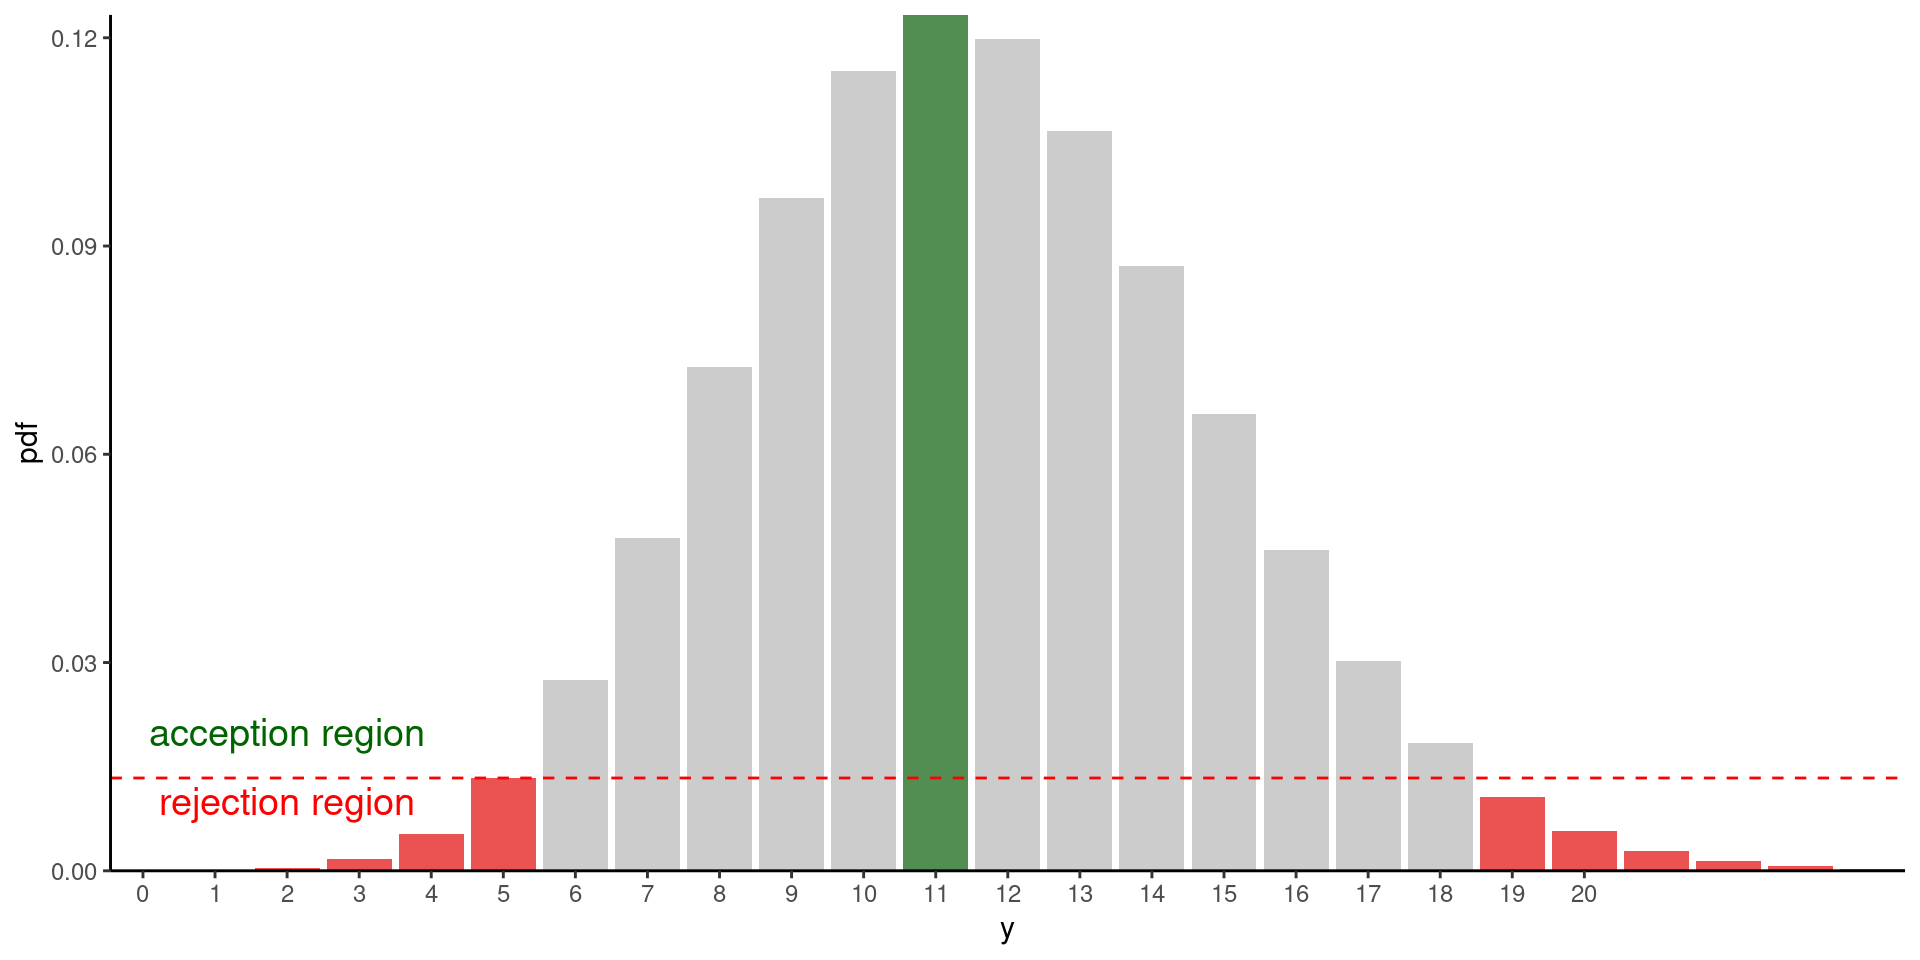

In [23]:
yy <- seq(0, n, len = n+1)

df_f <- data.frame(x = yy, pdf = dbinom(yy, n, p_0))


ggplot(data=df_f[1:25,], aes(x=yy[1:25], y=pdf[1:25])) +
geom_bar(stat="identity", fill="grey1", alpha = 0.2) +
geom_bar(aes(x=yy[12:12], y=pdf[1:1]), data=df_f[12:12,], stat="identity", fill='darkgreen', alpha=0.6)+
geom_bar(aes(x=yy[1:6], y=pdf[1:6]), data=df_f[1:6,], stat="identity", fill='red', alpha=0.6)+
geom_bar(aes(x=yy[20:25], y=pdf[1:6]), data=df_f[20:25,], stat="identity", fill='red', alpha=0.6)+
geom_hline(aes(yintercept = dbinom(cuts$left, n, p_0)), linewidth = 0.8, color = 'red', linetype = 'dashed') +
annotate(geom="text", x=2, y=0.02, label="acception region",
              color="darkgreen", size=8) +
annotate(geom="text", x=2, y=0.01, label="rejection region",
              color="red", size=8) +
scale_x_continuous(name = 'y', expand = c(0,0), breaks = 0:20) +
scale_y_continuous(name = 'pdf', expand = c(0,0)) +
theme_classic(base_size=18)

As it can be seen, value y=11 lies in the acceptance of the Null Hypothesis region.

### • a new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter X level

In [24]:
n_new <- 165
y_new <- 9

### e) find the frequentist estimator for $p$

In [25]:
p_f_new <- y_new/n_new
sigma_f_new <- sqrt(p_f_new*(1 - p_f_new)/n_new)

cat('Frequentist estimator of detecting the bacteria in water sample:',
    round(p_f_new,3), '\n')
cat('Standard deviation:', round(sigma_f_new,3))

Frequentist estimator of detecting the bacteria in water sample: 0.055 
Standard deviation: 0.018

### f) find a bayesian estimator for $p$, assuming both a Beta(1, 10) prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.

In [26]:
alpha_post_new <- alpha_prior + y_new
beta_post_new <- beta_prior + n_new - y_new

alpha_post_new2 <- alpha_post + y_new
beta_post_new2 <- beta_post + n_new - y_new

posterior_bayes_new <- dbeta(p, alpha_post_new, beta_post_new)
posterior_bayes_new2 <- dbeta(p, alpha_post_new2, beta_post_new2)

### g) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval

In [27]:
vars_new <- mean_std_limits(alpha_post_new, beta_post_new, 0.025)
mean_post_new <- vars_new$mean
std_post_new <- vars_new$std
lower_limit_new <- vars_new$lower
upper_limit_new <- vars_new$upper

vars_new2 <- mean_std_limits(alpha_post_new2, beta_post_new2, 0.025)
mean_post_new2 <- vars_new2$mean
std_post_new2 <- vars_new2$std
lower_limit_new2 <- vars_new2$lower
upper_limit_new2 <- vars_new2$upper

cat('Mean of the posterior with Beta prior (Bayesian estimator):', round(mean_post_new,3), '\n')
cat('Variance of the posterior with Beta prior:', std_post_new**2, '\n')

cat('Mean of the posterior with the previous posterior as a prior (Bayesian estiamtor):', round(mean_post_new2,3), '\n')
cat('Variance of the posterior with the previous posterior as a prior:', std_post_new2**2, '\n')

Mean of the posterior with Beta prior (Bayesian estimator): 0.057 
Variance of the posterior with Beta prior: 9.166826e-08 
Mean of the posterior with the previous posterior as a prior (Bayesian estiamtor): 0.072 
Variance of the posterior with the previous posterior as a prior: 5.189321e-08 


Warning message:
“Removed 800 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 800 rows containing missing values (`geom_line()`).”


Posterior1 is the posterior with Beta prior, posterior2 is a posterior with the previous posterior as a prior.

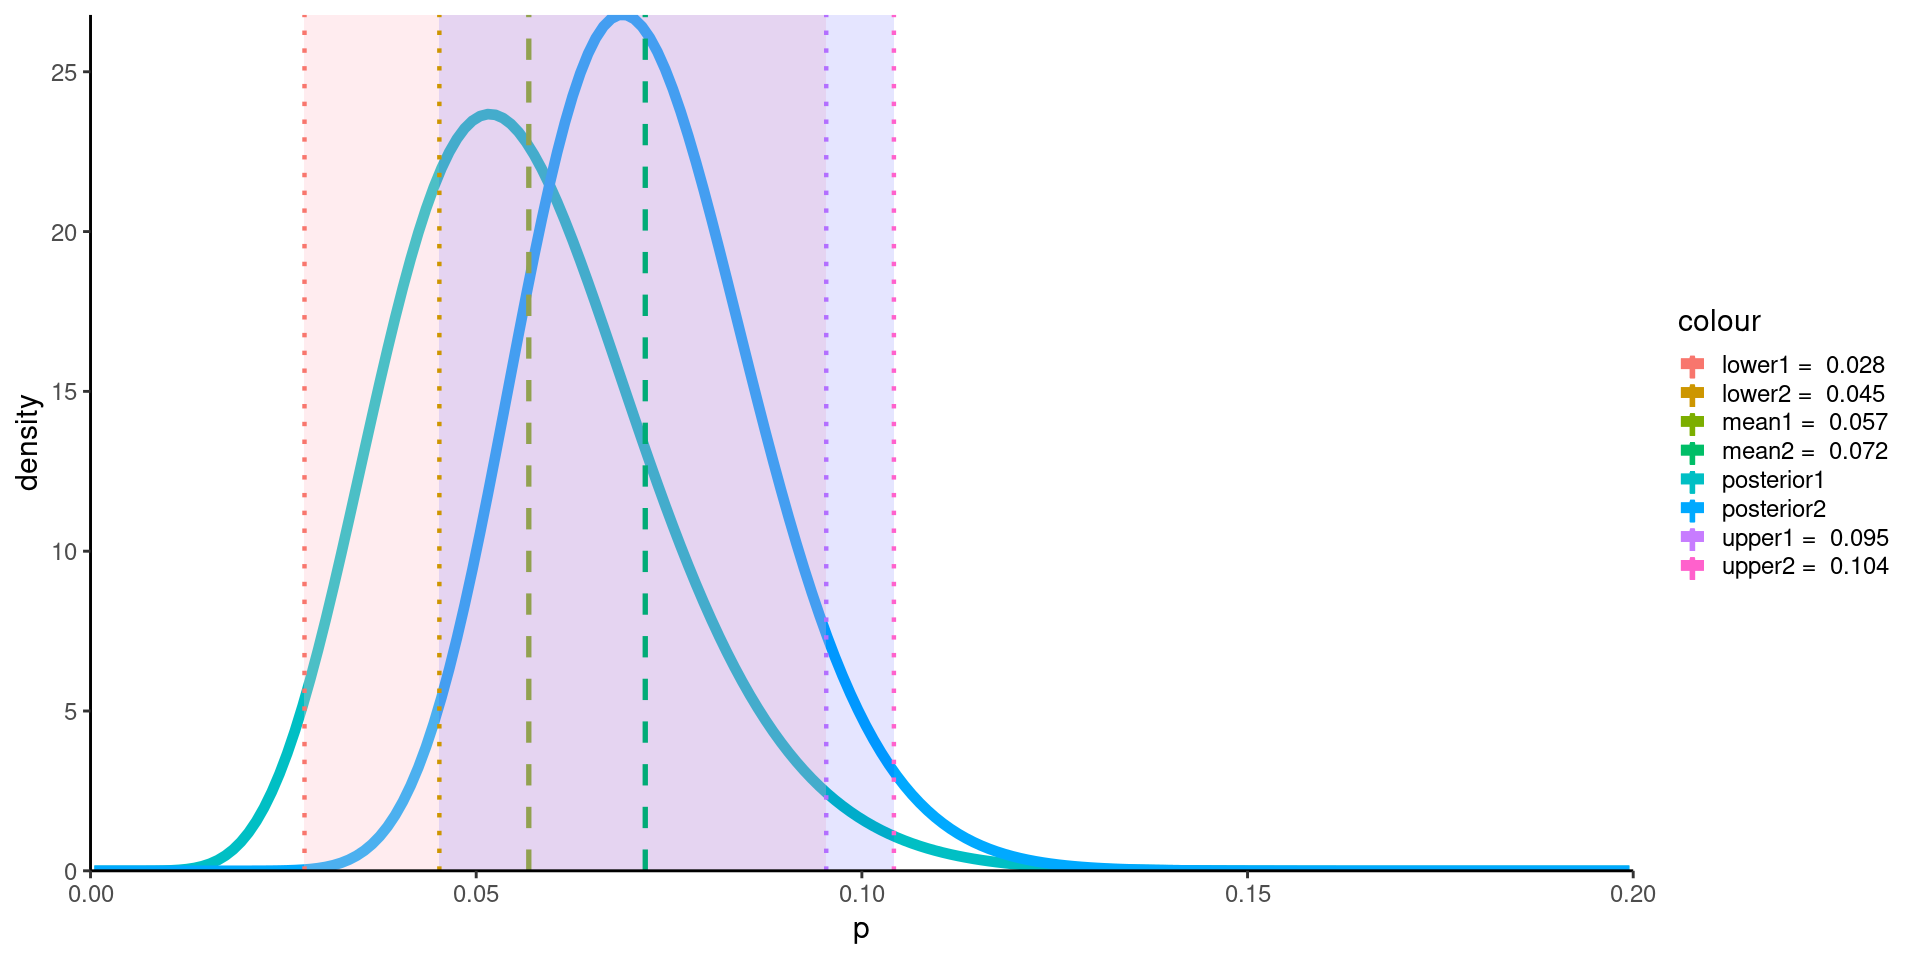

In [28]:
ggplot() +
geom_line(aes(x = p, y = posterior_bayes_new, colour = 'posterior1'), linewidth = 3) +
geom_line(aes(x = p, y = posterior_bayes_new2, colour = 'posterior2'), linewidth = 3) +

geom_vline(aes(xintercept = mean_post_new, colour = paste('mean1 = ', round(mean_post_new,3))),
           linetype = 'dashed', linewidth = 1.5) +
geom_ribbon(aes(y = posterior_bayes_new2, xmax = upper_limit_new,
                xmin = lower_limit_new),
            fill = 'pink', alpha=0.3) +

geom_vline(aes(xintercept = lower_limit_new, colour = paste('lower1 = ', round(lower_limit_new,3))),
           linetype = 'dotted', linewidth = 1.25) +
geom_vline(aes(xintercept = upper_limit_new,
               colour = paste('upper1 = ', round(upper_limit_new,3))),
           linetype = 'dotted', linewidth = 1.25) +

geom_vline(aes(xintercept = mean_post_new2, colour = paste('mean2 = ', round(mean_post_new2,3))),
           linetype = 'dashed', linewidth = 1.5) +
geom_ribbon(aes(y = posterior_bayes_new2, xmax = upper_limit_new2,
                xmin = lower_limit_new2),
            fill = 'blue', alpha=0.1) +

geom_vline(aes(xintercept = lower_limit_new2, colour = paste('lower2 = ', round(lower_limit_new2,3))),
           linetype = 'dotted', linewidth = 1.25) +
geom_vline(aes(xintercept = upper_limit_new2,
               colour = paste('upper2 = ', round(upper_limit_new2,3))),
           linetype = 'dotted', linewidth = 1.25) +

theme_classic(base_size=18) +
scale_x_continuous(name= 'p',expand = c(0, 0), limits = c(0, 0.2))+
scale_y_continuous(name = 'density', expand = c(0, 0))

cat('Posterior1 is the posterior with Beta prior, posterior2 is a posterior with the previous posterior as a prior.')

### h) test the hypotesis

$$
H_0 : p = 0.1 \; \text{versus} \; H_1 : p \neq 0.1 
$$

### at 5% level of significance with both the frequentist and bayesian approach

1) Bayesian approach

In [29]:
p_0 <- 0.1

cat('Case with Beta prior: \n')
if (p_0 > lower_limit_new & p_0 < upper_limit_new){
    cat('Null Hypothesis is accepted. \n')
} else {cat('Null Hypothesis is rejected. \n')}

cat('Case with the previous posterior as a prior: \n')
if (p_0 > lower_limit_new2 & p_0 < upper_limit_new2){
    cat('Null Hypothesis is accepted. \n')
} else {cat('Null Hypothesis is rejected. \n')}

Case with Beta prior: 
Null Hypothesis is rejected. 
Case with the previous posterior as a prior: 
Null Hypothesis is accepted. 


2) Frequentist approach

-- Test on the second dataset without considering the previous one.

In [30]:
ign_cutl <- qbinom(0.025, n_new, p_0)
ign_cutr <- qbinom(0.975, n_new, p_0)

cat('Cuts: (', ign_cutl, ',' , ign_cutr,'). Area: ', pbinom(ign_cutl, n_new, p_0) + 1 - pbinom(ign_cutr, n_new, p_0), sep='')

Cuts: (9,24). Area: 0.0511155

In [31]:
cuts_new <- finding_cuts(p_0,n_new,ign_cutl,ign_cutr)
print(cuts_new)

$right
[1] 24

$left
[1] 9

$area
[1] 0.0511155



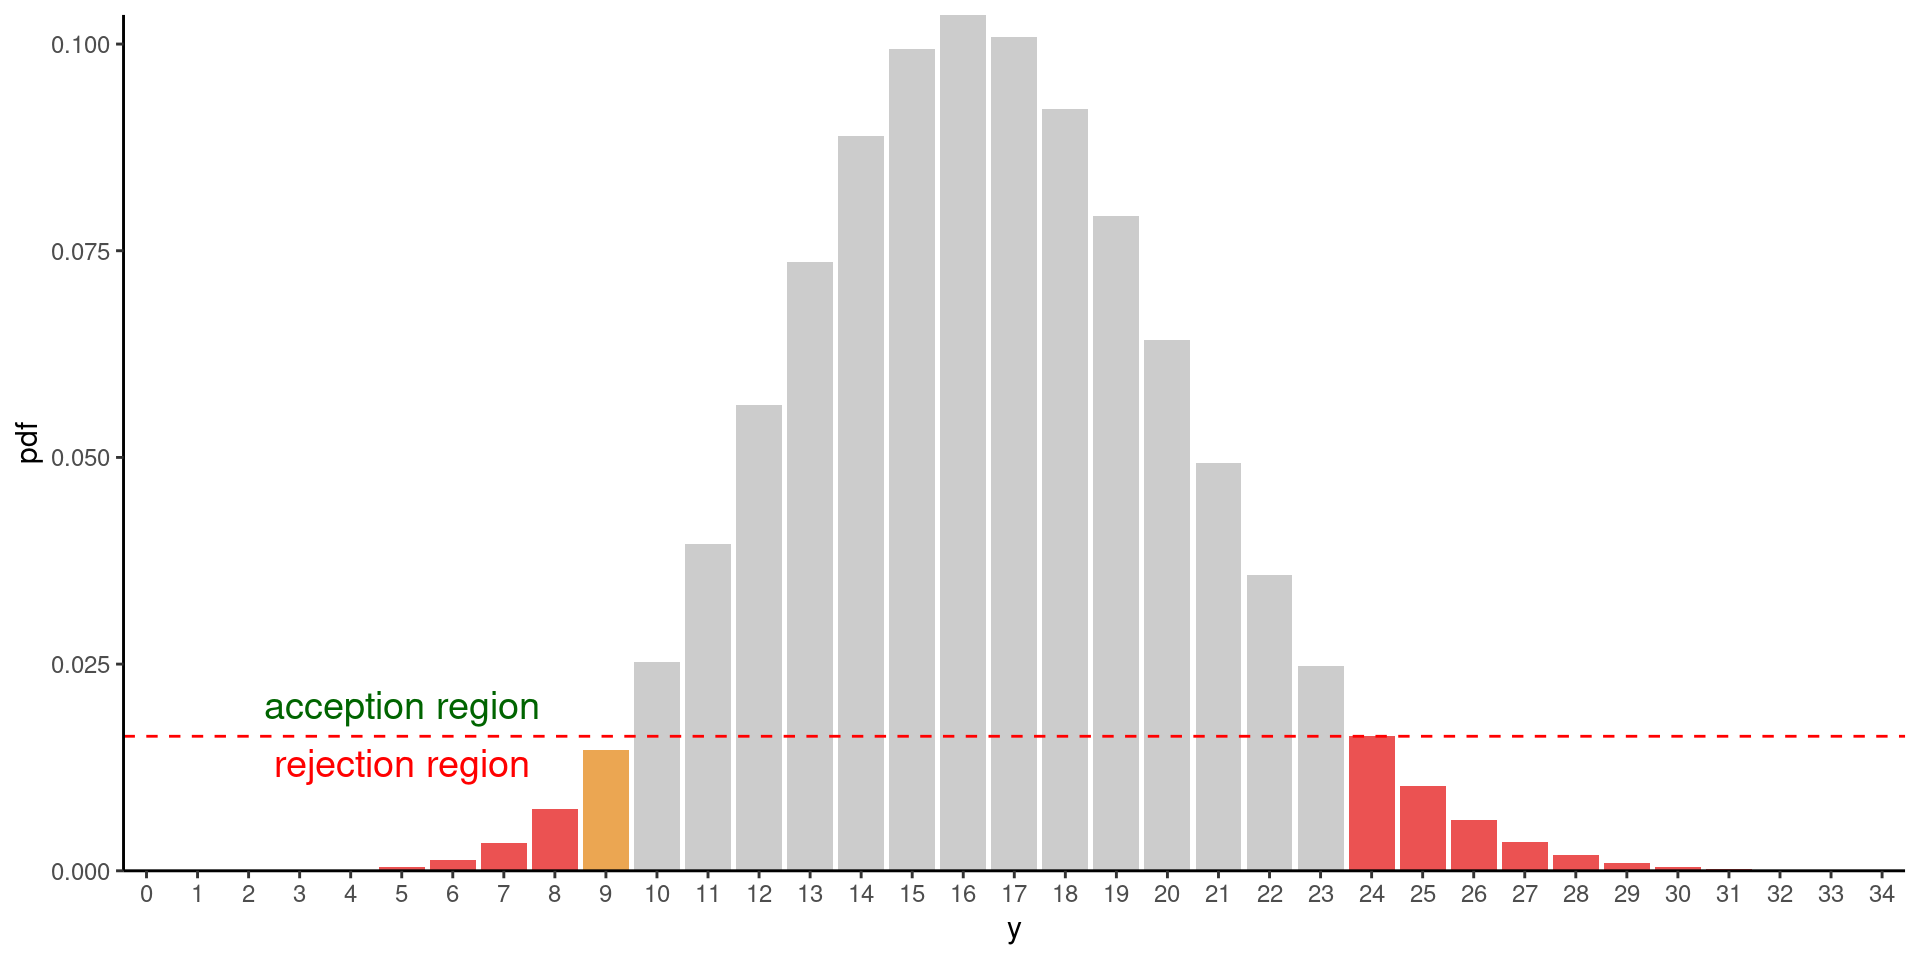

In [32]:
yy <- seq(0, n_new, len = n_new+1)

df_f <- data.frame(x = yy, pdf = dbinom(yy, n_new, p_0))


ggplot(data=df_f[1:35,], aes(x=yy[1:35], y=pdf[1:35])) +
geom_bar(stat="identity", fill="grey1", alpha = 0.2) +
geom_bar(aes(x=yy[10:10], y=pdf[1:1]), data=df_f[10:10,], stat="identity", fill='darkorange', alpha=0.6)+
geom_bar(aes(x=yy[1:9], y=pdf[1:9]), data=df_f[1:9,], stat="identity", fill='red', alpha=0.6)+
geom_bar(aes(x=yy[25:35], y=pdf[1:11]), data=df_f[25:35,], stat="identity", fill='red', alpha=0.6)+
geom_hline(aes(yintercept = dbinom(cuts_new$right, n_new, p_0)), linewidth = 0.8, color = 'red', linetype = 'dashed') +
annotate(geom="text", x=5, y=0.02, label="acception region",
              color="darkgreen", size=8) +
annotate(geom="text", x=5, y=0.013, label="rejection region",
              color="red", size=8) +
scale_x_continuous(name = 'y', expand = c(0,0), breaks = 0:35) +
scale_y_continuous(name = 'pdf', expand = c(0,0)) +
theme_classic(base_size=18)

The value of y lies in the rejection region.


- Test where I consider two datasets.

In [33]:
cat('Number of positive trials:', y+y_new)

Number of positive trials: 20

In [34]:
ign_cutl <- qbinom(0.025, n+n_new, p_0)
ign_cutr <- qbinom(0.975, n+n_new, p_0)

cat('Cuts: (', ign_cutl, ',' , ign_cutr,'). Area: ', pbinom(ign_cutl, n+n_new, p_0) + 1 - pbinom(ign_cutr, n+n_new, p_0), sep='')

Cuts: (19,38). Area: 0.06129034

In [35]:
cuts_new2 <- finding_cuts(p_0,n+n_new,ign_cutl,ign_cutr)
print(cuts_new2)

$right
[1] 39

$left
[1] 19

$area
[1] 0.05306414



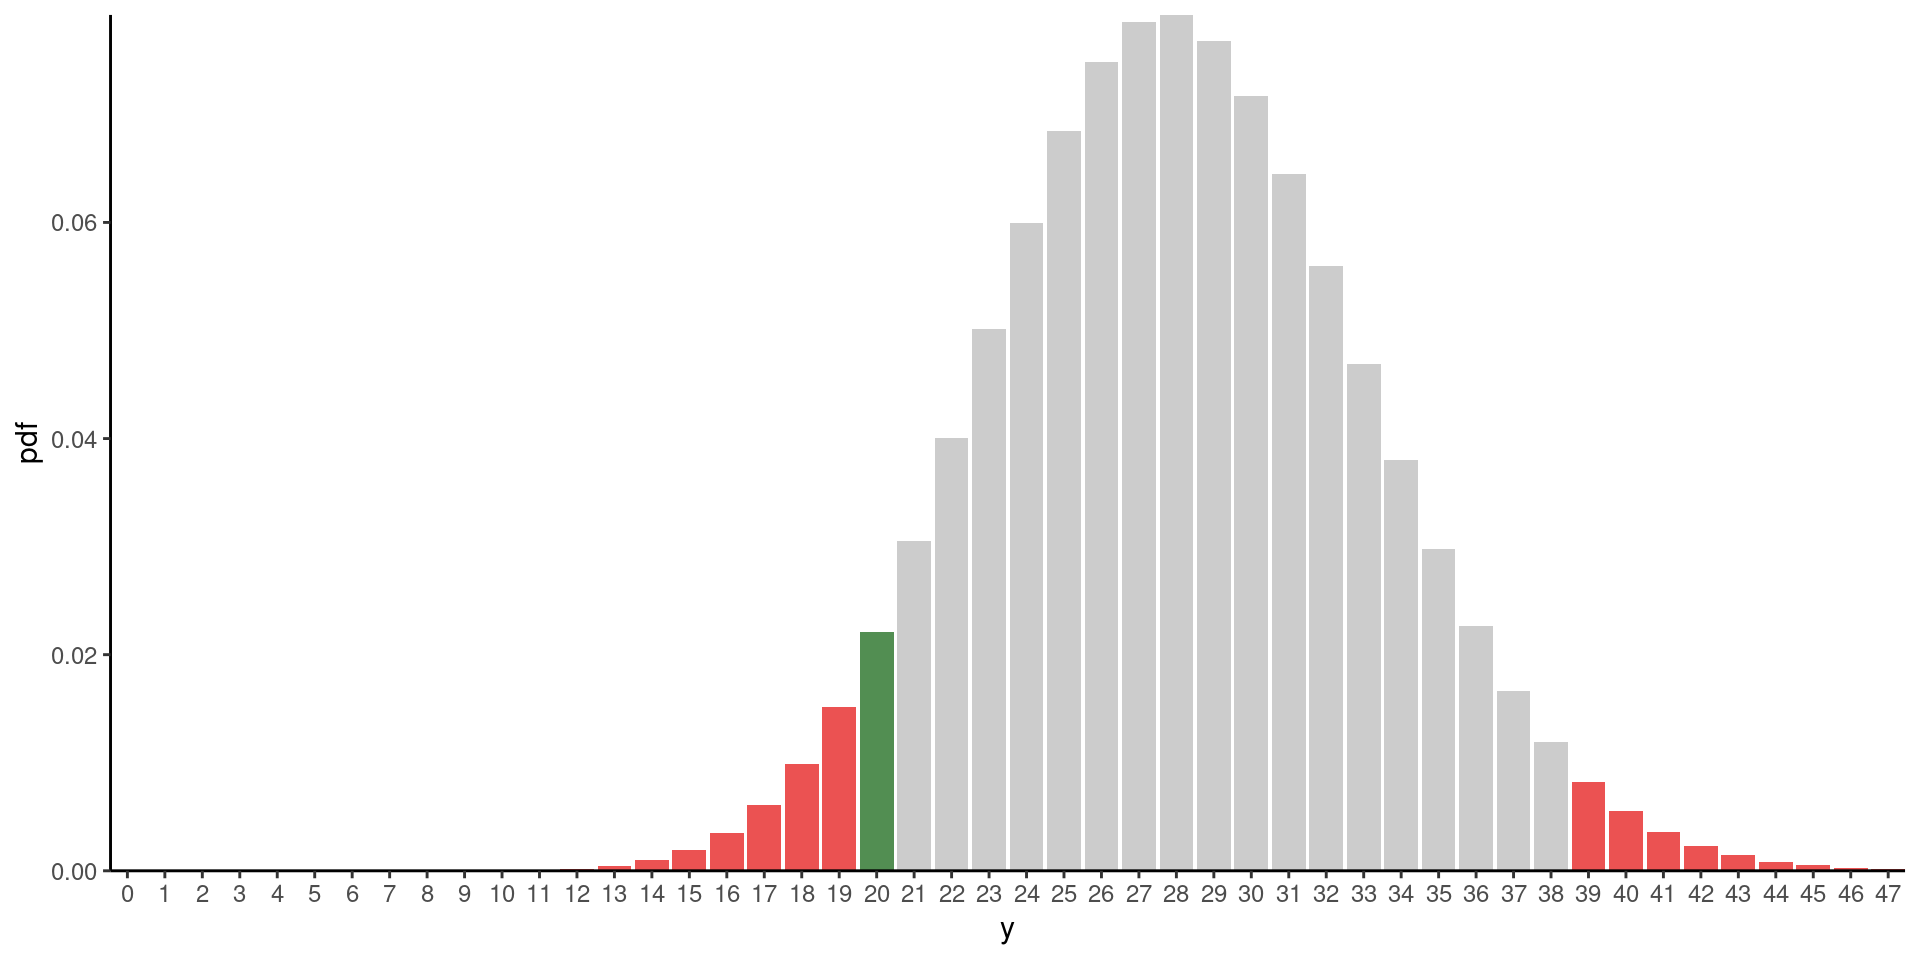

In [36]:
yy <- seq(0, n+n_new, len = n+n_new+1)

df_f <- data.frame(x = yy, pdf = dbinom(yy, n+n_new, p_0))


ggplot(data=df_f[0:48,], aes(x=yy[0:48], y=pdf[0:48])) +
geom_bar(stat="identity", fill="grey1", alpha = 0.2) +
geom_bar(aes(x=yy[21:21], y=pdf[1:1]), data=df_f[21:21,], stat="identity", fill='darkgreen', alpha=0.6)+
geom_bar(aes(x=yy[1:20], y=pdf[1:20]), data=df_f[1:20,], stat="identity", fill='red', alpha=0.6)+
geom_bar(aes(x=yy[40:48], y=pdf[1:9]), data=df_f[40:48,], stat="identity", fill='red', alpha=0.6)+
scale_x_continuous(name = 'y', expand = c(0,0), breaks = 0:60) +
scale_y_continuous(name = 'pdf', expand = c(0,0)) +
theme_classic(base_size=18)

As we can see, the y=20 lies in the acceptance region, although right on the border.


The results of the Hypothesis test in both frequentist and bayesian approaches are the same.

# Exercise 4

### • analyze the data of Exercise 3 and solve points (b) and (c) using a MCMC with JAGS

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 2
   Total graph size: 6

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
Y 10.92300 4.31837 0.0431837      0.0514842
p  0.09437 0.02574 0.0002574      0.0003513

2. Quantiles for each variable:

    2.5%    25%      50%     75%   97.5%
Y 4.0000 8.0000 11.00000 14.0000 20.0000
p 0.0496 0.0762  0.09252  0.1101  0.1501



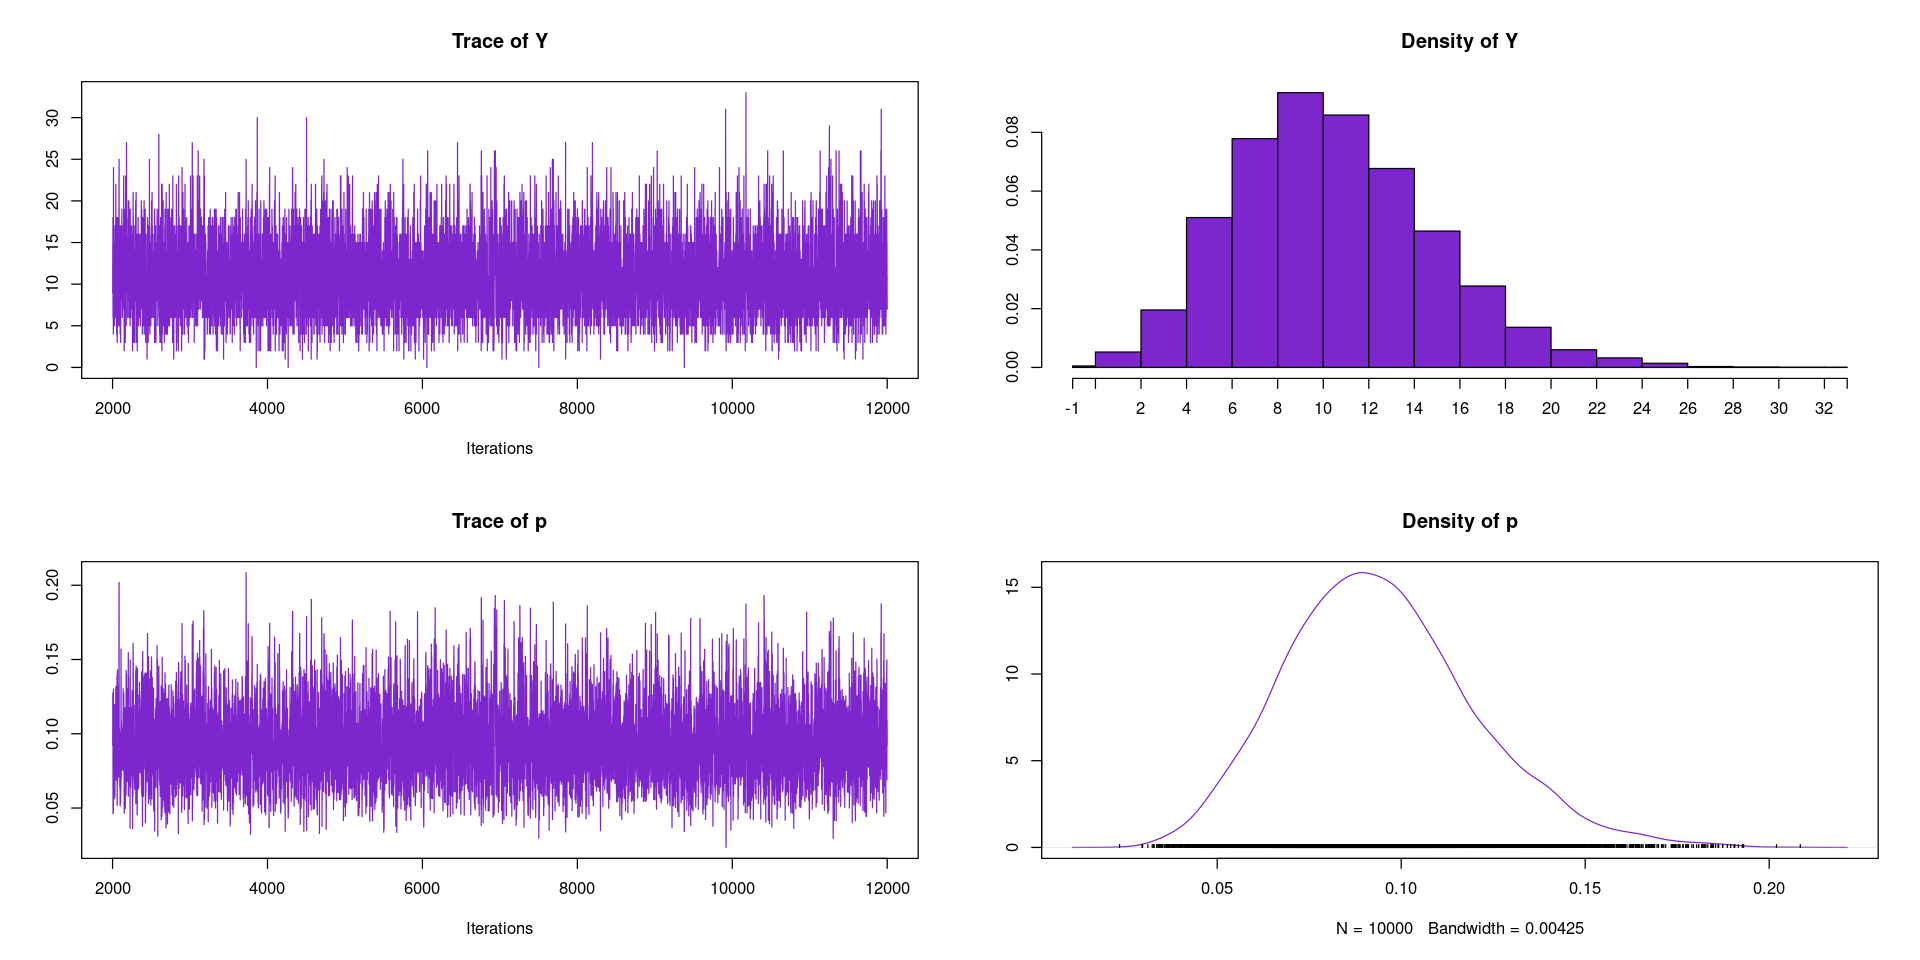

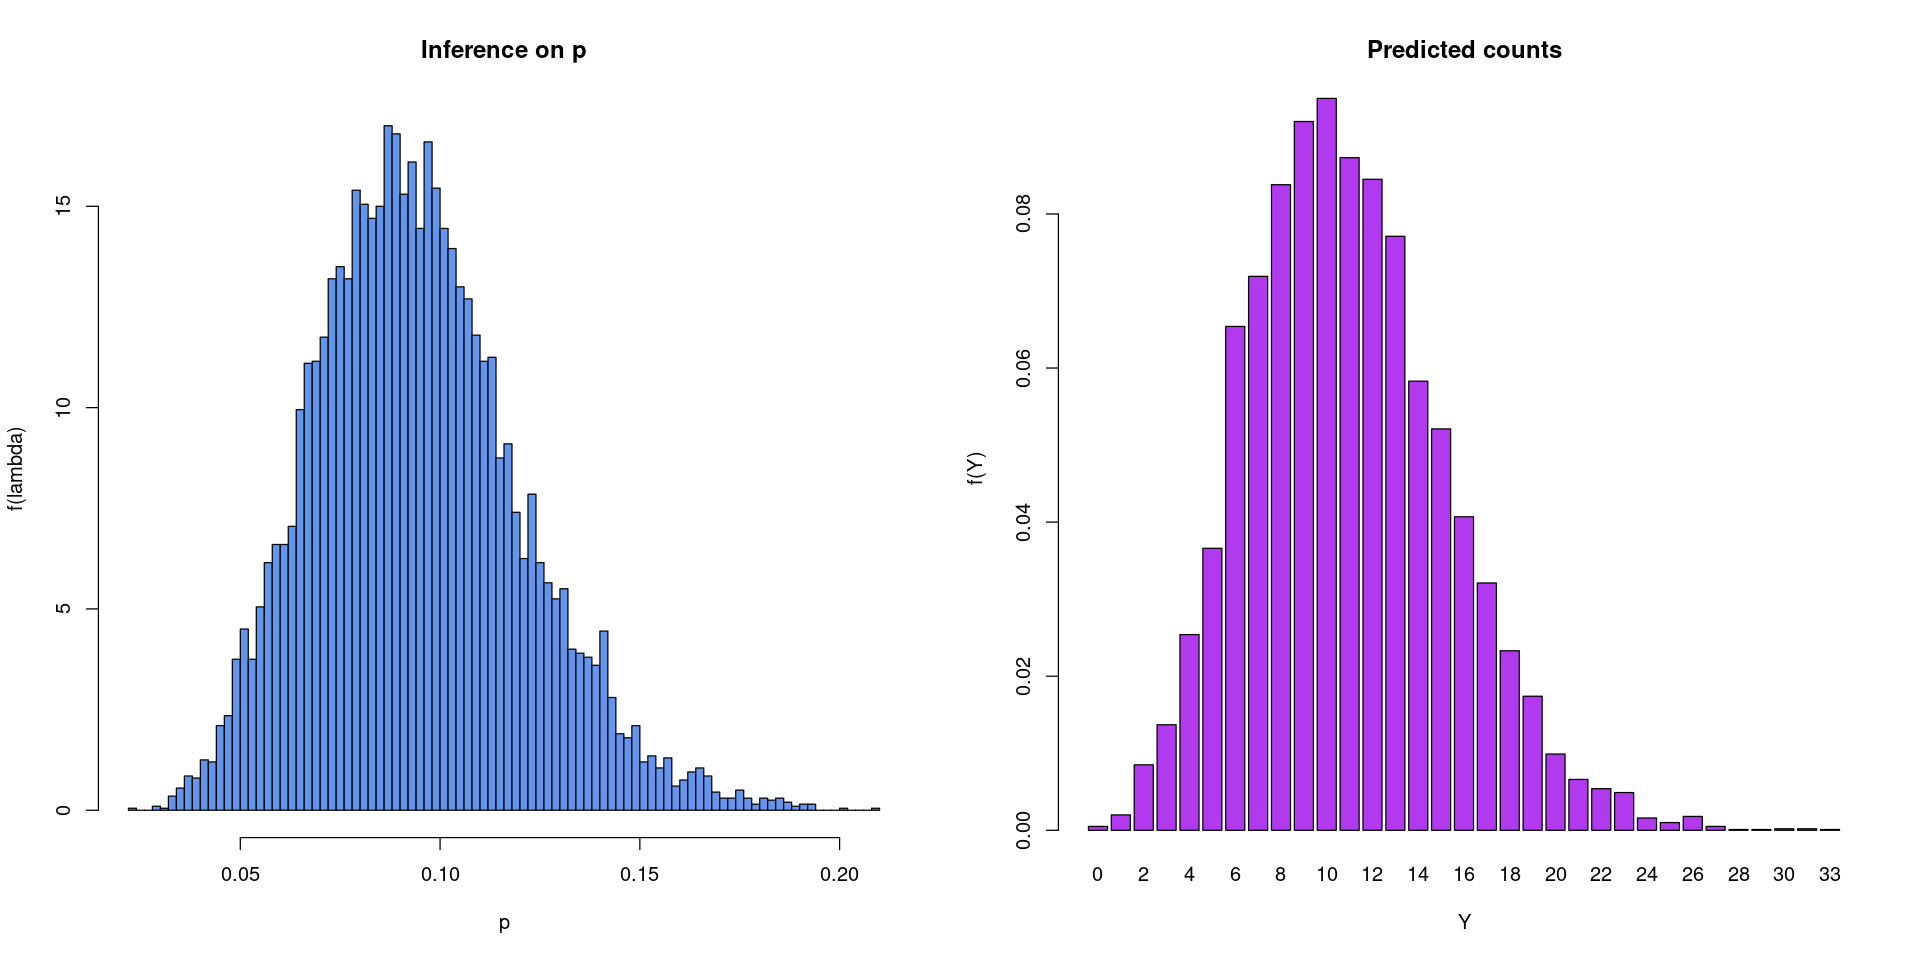

In [37]:
model_bact <- "model{
    #Likelihood
    for(i in 1:length(X)) {
        X[i] ~ dbin(p,n);
    }

    #Beta prior
    p ~ dbeta(alpha_prior, beta_prior);
    
    
    #Predicted data
    Y ~ dbin(p,n);
}"

data_bc <- NULL
data_bc$alpha_prior <- 1
data_bc$beta_prior <- 10
data_bc$X <- 11
data_bc$n <- 116


model_b <- jags.model(textConnection(model_bact), 
data = data_bc)
update(model_b, 1000)


chain_bact <- coda.samples(model = model_b, variable.names = c("p", "Y"),
                          n.iter = 10000)

plot(chain_bact, col='purple3')

print(summary(chain_bact))

options(repr.plot.width=16, repr.plot.height=8)
chain.dfbact <- as.data.frame(as.mcmc(chain_bact))
#
# Probability plots
par(mfrow=c(1,2))
hist(chain.dfbact$p , nc=100, prob=TRUE , col='cornflowerblue',
xlab='p', ylab='f(lambda)', main='Inference on p')
ty <- table(chain.dfbact$Y)
barplot(ty/sum(ty), col='darkorchid2', xlab='Y', ylab='f(Y)', main= sprintf('Predicted counts'))